In [1]:
import sys
sys.path.append('/PKEBenchmark')
import pke
!pip install datasets
!python -m spacy download en_core_web_sm
for path in sys.path:
    print(path)
print(pke.__file__)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
C:\Users\Ashraff\PKE-OurDataset
C:\ProgramData\Anaconda3\python39.zip
C:\ProgramData\Anaconda3\DLLs
C:\ProgramData\Anaconda3\lib
C:\ProgramData\Anaconda3

C:\Users\Ashraff\AppData\Roaming\Python\Python39\site-packages
C:\ProgramData\Anaconda3\lib\site-packages
C:\ProgramData\Anaconda3\lib\site-packages\win32
C:\ProgramData\Anaconda3\lib\site-packages\win32\lib
C:\ProgramData\Anaconda3\lib\site-packages\Pythonwin
/PKEBenchmark
C:\Users\Ashraff\PKE-OurDataset\pke\__init__.py


In [2]:
import spacy
from spacy.tokenizer import _get_regex_pattern

nlp = spacy.load("en_core_web_sm")

# Tokenization fix for in-word hyphens (e.g. 'non-linear' would be kept 
# as one token instead of default spacy behavior of 'non', '-', 'linear')
# https://spacy.io/usage/linguistic-features#native-tokenizer-additions

from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER
from spacy.lang.char_classes import CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.util import compile_infix_regex

# Modify tokenizer infix patterns
infixes = (
    LIST_ELLIPSES
    + LIST_ICONS
    + [
        r"(?<=[0-9])[+\-\*^](?=[0-9-])",
        r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
            al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
        ),
        r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
        # ✅ Commented out regex that splits on hyphens between letters:
        # r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
        r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
    ]
)

infix_re = compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer

In [3]:
from tqdm.notebook import tqdm
from datasets import load_dataset

# benchmark = "inspec"
# benchmark = "pake"
benchmark = "pakeNew"
# benchmark = "pake-m-2k"

# ayesha08/pake-m-2k


# dataset = load_dataset('ayesha08/'+benchmark)
dataset = load_dataset('foyez/'+benchmark)

# load the inspec dataset
# dataset = load_dataset("csv", data_files={'train': 'test.csv', 'test': 'test1.csv'}, column_names=["title", "abstract"])

# pre-process training and test splits
train = []
for sample in tqdm(dataset['train']):
    train.append(nlp(sample["title"]+". "+sample["abstract"]))
test = []
for sample in tqdm(dataset['test']):
    test.append(nlp(sample["title"]+". "+sample["abstract"]))

Using custom data configuration foyez--pakeNew-a9722485006b1613
Reusing dataset csv (C:\Users\Ashraff\.cache\huggingface\datasets\foyez___csv\foyez--pakeNew-a9722485006b1613\0.0.0\51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [4]:
from pke import compute_document_frequency, compute_lda_model
from string import punctuation


# computing LDA and DF counts

compute_document_frequency(
    documents=train,
    output_file='data/{}.df.gz'.format(benchmark),
    language='en',              # language of the input files
    normalization='stemming',   # use porter stemmer
    stoplist=list(punctuation), # stoplist (punctuation marks)
    n=5                         # compute n-grams up to 5-grams
)

compute_lda_model(
    documents=train,
    output_file="data/{}.lda.pickle.gz".format(benchmark),
    n_topics=500,               # number of topics
    language='en',              # language of the input files
    stoplist=list(punctuation), # stoplist (punctuation marks)
    normalization='stemming'    # use porter stemmer
)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
from pke import load_document_frequency_file, load_lda_model

df = load_document_frequency_file(input_file='data/{}.df.gz'.format(benchmark))
lda_model = load_lda_model(input_file="data/{}.lda.pickle.gz".format(benchmark))

In [6]:
from pke.unsupervised import *

from timeit import default_timer as timer

outputs = {}
elapsed_times = {}
for model in [TfIdf, FirstPhrases, YAKE, PAKE]:
    outputs[model.__name__] = []
    
    extractor = model()
    start = timer()
    for i, doc in enumerate(tqdm(test)):
        extractor.load_document(input=doc, language='en')
        extractor.grammar_selection(grammar="NP: {<ADJ>*<NOUN|PROPN>+}")
        if model.__name__ in ["TfIdf"]:
            extractor.candidate_weighting(df=df)
        elif model.__name__ in ["TopicalPageRank"]:
            extractor.candidate_weighting(lda_model=lda_model)
        else:
            extractor.candidate_weighting()
        outputs[model.__name__].append([u for u,v in extractor.get_n_best(n=10, stemming=True)])
    end = timer()
    elapsed_times[model.__name__] = end - start
    #print("Elapsed time for {}: {:.2f}s - {:.2f} it/s".format(model.__name__, end - start,  len(test) / (end - start))) 

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

word*******************************
react
tag*******************************
NN
word*******************************
web
tag*******************************
NN
word*******************************
application
tag*******************************
NN
word*******************************
with
tag*******************************
IN
word*******************************
business
tag*******************************
NN
word*******************************
process
tag*******************************
NN
word*******************************
management
tag*******************************
NN
word*******************************
complexity
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
the
tag*******************************
DT
word*******************************
implementation
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*******************

tag*******************************
CD
word*******************************
crew
tag*******************************
NN
word*******************************
cab
tag*******************************
NN
word*******************************
,
tag*******************************
,
word*******************************
all
tag*******************************
DT
word*******************************
the
tag*******************************
DT
word*******************************
electrical
tag*******************************
JJ
word*******************************
options
tag*******************************
NNS
word*******************************
have
tag*******************************
VB
word*******************************
new
tag*******************************
JJ
word*******************************
oem
tag*******************************
NN
word*******************************
replacement
tag*******************************
NN
word*******************************
!
tag*******************************
.
word******

tag*******************************
VB
word*******************************
copied
tag*******************************
VBN
word*******************************
and
tag*******************************
CC
word*******************************
pasted
tag*******************************
VBN
word*******************************
in
tag*******************************
IN
Weight*****************************************
{'data entry job': 0.00013249758655900937, 'pages': 0.033994814389079614, 'pdf file': 0.009454127006374213, 'data': 0.06798962877815923, 'excel': 0.06798962877815923}
BEST ASC*******************************************
['data entry job', 'pdf file', 'pages', 'data', 'excel']
After checking Similarity**********************
['data entry job', 'pdf file', 'pages', 'data', 'excel']
Top 10*****************************************
********************************************
word*******************************
mqtt
tag*******************************
NN
word*******************************
linux


tag*******************************
JJ
word*******************************
in
tag*******************************
IN
word*******************************
which
tag*******************************
WDT
word*******************************
professional
tag*******************************
JJ
word*******************************
reduce
tag*******************************
VB
word*******************************
large
tag*******************************
JJ
word*******************************
pieces
tag*******************************
NNS
word*******************************
of
tag*******************************
IN
word*******************************
wholesale
tag*******************************
NN
word*******************************
(
tag*******************************
(
word*******************************
primals
tag*******************************
NNS
word*******************************
)
tag*******************************
)
word*******************************
retail
tag*******************************
JJ

tag*******************************
NN
word*******************************
on
tag*******************************
IN
word*******************************
squarespace
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
you
tag*******************************
PRP
word*******************************
will
tag*******************************
MD
word*******************************
build
tag*******************************
NN
word*******************************
orgsnization
tag*******************************
NN
word*******************************
with
tag*******************************
IN
word*******************************
donation
tag*******************************
NN
word*******************************
in
tag*******************************
IN
word*******************************
built
tag*******************************
NN
word*******************************
form
tag*******************************
NN
w

tag*******************************
NN
word*******************************
both
tag*******************************
DT
word*******************************
creatively
tag*******************************
RB
word*******************************
analytically
tag*******************************
RB
word*******************************
in
tag*******************************
IN
word*******************************
subjects
tag*******************************
NNS
word*******************************
candidate
tag*******************************
NN
word*******************************
preferance
tag*******************************
NN
word*******************************
:
tag*******************************
:
word*******************************
from
tag*******************************
IN
word*******************************
thearijen
tag*******************************
NN
word*******************************
education
tag*******************************
NN
word*******************************
technology
tag*********

tag*******************************
IN
word*******************************
these
tag*******************************
DT
word*******************************
graphics
tag*******************************
NNS
word*******************************
outlines
tag*******************************
NNS
word*******************************
children
tag*******************************
NNS
word*******************************
colour
tag*******************************
NN
word*******************************
like
tag*******************************
IN
word*******************************
this
tag*******************************
DT
word*******************************
:
tag*******************************
:
word*******************************
scroll
tag*******************************
NN
word*******************************
bottom
tag*******************************
NN
word*******************************
see
tag*******************************
VB
word*******************************
it
tag*******************************
PR

tag*******************************
NNS
word*******************************
)
tag*******************************
)
word*******************************
.
tag*******************************
.
word*******************************
i
tag*******************************
NN
word*******************************
have
tag*******************************
VB
word*******************************
of
tag*******************************
IN
word*******************************
file
tag*******************************
NN
word*******************************
where
tag*******************************
WRB
word*******************************
all
tag*******************************
DT
word*******************************
the
tag*******************************
DT
word*******************************
should
tag*******************************
MD
word*******************************
be
tag*******************************
VB
word*******************************
copied
tag*******************************
VBN
word*******************

tag*******************************
NN
word*******************************
me
tag*******************************
PRP
Weight*****************************************
{'us project makeover require': 0.003277092883611018, 'us project makeover': 0.08381526164943048, 'requirements': 0.15045553578931245, 'non us resident': 0.17710142567887938, 'query': 0.20510344265804703}
BEST ASC*******************************************
['us project makeover require', 'us project makeover', 'requirements', 'non us resident', 'query']
After checking Similarity**********************
['us project makeover require', 'requirements', 'non us resident', 'query']
Top 10*****************************************
********************************************
word*******************************
assistant
tag*******************************
NN
word*******************************
for
tag*******************************
IN
word*******************************
a
tag*******************************
DT
word*********************

tag*******************************
IN
word*******************************
chart
tag*******************************
NN
Weight*****************************************
{'autodesk maya rig creation': 1.3154934254370106e-05, 'rig create': 0.009158294109074054, 'maya': 0.06674210357017195, 'file': 0.13597385229932193, 'exact details': 0.01883716678564527, 'chart': 0.13597385229932193}
BEST ASC*******************************************
['autodesk maya rig creation', 'rig create', 'exact details', 'maya', 'file', 'chart']
After checking Similarity**********************
['autodesk maya rig creation', 'rig create', 'exact details', 'maya', 'file', 'chart']
Top 10*****************************************
********************************************
word*******************************
need
tag*******************************
NN
word*******************************
a
tag*******************************
DT
word*******************************
sticker
tag*******************************
NN
word*********

tag*******************************
RB
word*******************************
sath
tag*******************************
NN
word*******************************
kr
tag*******************************
NN
word*******************************
sake
tag*******************************
NN
word*******************************
...
tag*******************************
:
word*******************************
///---
tag*******************************
NN
Weight*****************************************
{'urgent': 0.07469188814877338, 'person': 0.047262289370948986, 'social media work///forever living': 1.5280770562803797e-05, 'people': 0.14696710660890444, 'social media': 0.00673210013922397, 'instagram': 0.10136054389849711, 'facebook': 0.10136054389849711, 'linkedin': 0.10136054389849711, 'hindi speaker': 0.015121932232711358, 'mujhe bhot urgent': 0.0016810884326724264, 'hai 10person': 0.07481597642458927, 'ki jo mere sath work': 1.0579254429183098, 'sake': 0.235249407908667}
BEST ASC****************************

tag*******************************
IN
word*******************************
task
tag*******************************
NN
word*******************************
is
tag*******************************
VBZ
word*******************************
well
tag*******************************
RB
word*******************************
defined
tag*******************************
VBN
word*******************************
we
tag*******************************
PRP
word*******************************
will
tag*******************************
MD
word*******************************
share
tag*******************************
NN
word*******************************
details
tag*******************************
NNS
word*******************************
over
tag*******************************
IN
word*******************************
call
tag*******************************
NN
word*******************************
you
tag*******************************
PRP
word*******************************
should
tag*******************************
MD
word*

tag*******************************
PRP$
word*******************************
book
tag*******************************
NN
word*******************************
,
tag*******************************
,
word*******************************
where
tag*******************************
WRB
word*******************************
can
tag*******************************
MD
word*******************************
display
tag*******************************
NN
word*******************************
all
tag*******************************
DT
word*******************************
published
tag*******************************
VBN
word*******************************
books
tag*******************************
NNS
word*******************************
and
tag*******************************
CC
word*******************************
have
tag*******************************
VB
word*******************************
writers
tag*******************************
NNS
word*******************************
apply
tag*******************************
VB
w

tag*******************************
VBN
word*******************************
for
tag*******************************
IN
word*******************************
youtube
tag*******************************
NN
word*******************************
linkedin
tag*******************************
NN
word*******************************
music
tag*******************************
NN
word*******************************
added
tag*******************************
VBD
word*******************************
in
tag*******************************
IN
word*******************************
the
tag*******************************
DT
word*******************************
backgroud
tag*******************************
NN
word*******************************
text
tag*******************************
NN
word*******************************
overlays
tag*******************************
NNS
word*******************************
front
tag*******************************
NN
word*******************************
thumbnail
tag**************************

tag*******************************
VBG
word*******************************
databases
tag*******************************
NNS
word*******************************
on
tag*******************************
IN
word*******************************
our
tag*******************************
PRP$
word*******************************
oscommerce
tag*******************************
NN
word*******************************
website
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
move
tag*******************************
NN
word*******************************
it
tag*******************************
PRP
word*******************************
onto
tag*******************************
IN
word*******************************
the
tag*******************************
DT
word*******************************
latest
tag*******************************
JJS
word*******************************
open
tag*******************************
JJ

tag*******************************
VB
word*******************************
sba
tag*******************************
NN
word*******************************
7a
tag*******************************
CD
word*******************************
loan
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
i
tag*******************************
NN
word*******************************
m
tag*******************************
NN
word*******************************
looking
tag*******************************
VBG
word*******************************
cpa
tag*******************************
NN
word*******************************
cfo
tag*******************************
NN
word*******************************
with
tag*******************************
IN
word*******************************
some
tag*******************************
DT
word*******************************
accounting
tag*******************************
NN
word***************

tag*******************************
NN
word*******************************
giving
tag*******************************
VBG
word*******************************
details
tag*******************************
NNS
word*******************************
about
tag*******************************
IN
word*******************************
whether
tag*******************************
IN
word*******************************
should
tag*******************************
MD
word*******************************
go
tag*******************************
VB
word*******************************
for
tag*******************************
IN
word*******************************
what
tag*******************************
WP
word*******************************
cost
tag*******************************
NN
word*******************************
kindly
tag*******************************
RB
word*******************************
address
tag*******************************
NN
word*******************************
following
tag*****************************

tag*******************************
NN
word*******************************
api
tag*******************************
NN
word*******************************
or
tag*******************************
CC
word*******************************
from
tag*******************************
IN
word*******************************
other
tag*******************************
JJ
word*******************************
platform
tag*******************************
NN
Weight*****************************************
{'video conference': 0.0011505673016562188, 'whiteboard': 0.016135544337763354, 'live chat': 0.0007834369865436034, 'marketing': 0.0356122171604505, 'tools': 0.0356122171604505, 'website': 0.03972508120803817, 'android': 0.03972508120803817, 'mac': 0.027928357261093478, 'windows': 0.03972508120803817, 'app video conference': 4.582590995392782e-05, 'marketing tools': 0.0012698404608648417, 'custom': 0.03972508120803817, 'integrate video call api': 0.0009125886259984344, 'whiteboard api': 0.0011505673016562188, 'o

tag*******************************
NN
word*******************************
am
tag*******************************
VBP
word*******************************
looking
tag*******************************
VBG
word*******************************
for
tag*******************************
IN
word*******************************
a
tag*******************************
DT
word*******************************
who
tag*******************************
WP
word*******************************
can
tag*******************************
MD
word*******************************
work
tag*******************************
NN
word*******************************
on
tag*******************************
IN
word*******************************
my
tag*******************************
PRP$
word*******************************
several
tag*******************************
JJ
word*******************************
project
tag*******************************
NN
word*******************************
management
tag*******************************
NN
Weight*

tag*******************************
JJ
word*******************************
mention
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
then
tag*******************************
RB
word*******************************
only
tag*******************************
RB
word*******************************
bid
tag*******************************
NN
word*******************************
this
tag*******************************
DT
word*******************************
is
tag*******************************
VBZ
word*******************************
long
tag*******************************
RB
word*******************************
term
tag*******************************
NN
word*******************************
projects
tag*******************************
NNS
word*******************************
preferring
tag*******************************
VBG
word*******************************
indian
tag*******************************
JJ


********************************************
word*******************************
reading
tag*******************************
NN
word*******************************
response
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
your
tag*******************************
PRP$
word*******************************
prompt
tag*******************************
NN
word*******************************
for
tag*******************************
IN
word*******************************
this
tag*******************************
DT
word*******************************
first
tag*******************************
RB
word*******************************
:
tag*******************************
:
word*******************************
using
tag*******************************
VBG
word*******************************
the
tag*******************************
DT
word*******************************
sources
tag*******************************
NNS

********************************************
word*******************************
pdf
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
excel
tag*******************************
NN
word*******************************
conversion
tag*******************************
NN
word*******************************
admin
tag*******************************
NN
word*******************************
activity
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
we
tag*******************************
PRP
word*******************************
have
tag*******************************
VB
word*******************************
a
tag*******************************
DT
word*******************************
listing
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*

tag*******************************
NN
word*******************************
pplication
tag*******************************
NN
word*******************************
which
tag*******************************
WDT
word*******************************
are
tag*******************************
VBP
word*******************************
trying
tag*******************************
VBG
word*******************************
to
tag*******************************
TO
word*******************************
move
tag*******************************
NN
word*******************************
model
tag*******************************
NN
word*******************************
looking
tag*******************************
VBG
word*******************************
re-architect
tag*******************************
NN
word*******************************
the
tag*******************************
DT
word*******************************
from
tag*******************************
IN
word*******************************
single
tag**************************

tag*******************************
PRP
word*******************************
have
tag*******************************
VB
word*******************************
draw
tag*******************************
NN
word*******************************
up
tag*******************************
RB
Weight*****************************************
{'pe': 99999991725.96358, 'company': 0.046450921266402906, 'spcc plan': 0.003859559337838896, 'sweetex': 0.10027892447522002, 'inc': 0.10027892447522002, 'distributor': 0.1447040433775792, 'corn sweeteners': 0.021387090011853897, 'soy bean': 0.021387090011853897, 'vegatable oil': 0.027640654309033258, 'business': 0.19774918096259858, 'lease': 0.19774918096259858, 'bnsf railroad': 0.019904192441218174}
BEST ASC*******************************************
['spcc plan', 'bnsf railroad', 'corn sweeteners', 'soy bean', 'vegatable oil', 'company', 'sweetex', 'inc', 'distributor', 'business', 'lease', 'pe']
After checking Similarity**********************
['spcc plan', 'bnsf rai

tag*******************************
IN
word*******************************
kartra
tag*******************************
NN
word*******************************
the
tag*******************************
DT
word*******************************
should
tag*******************************
MD
word*******************************
contain
tag*******************************
NN
word*******************************
12
tag*******************************
CD
word*******************************
modules
tag*******************************
NNS
word*******************************
including
tag*******************************
VBG
word*******************************
outline
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*******************************
content
tag*******************************
NN
word*******************************
following
tag*******************************
VBG
word*******************************
:
tag****************************

tag*******************************
PRP
word*******************************
have
tag*******************************
VB
word*******************************
to
tag*******************************
TO
word*******************************
enter
tag*******************************
NN
word*******************************
all
tag*******************************
DT
word*******************************
income
tag*******************************
NN
word*******************************
then
tag*******************************
RB
word*******************************
second
tag*******************************
JJ
word*******************************
expenditure
tag*******************************
NN
word*******************************
with
tag*******************************
IN
word*******************************
some
tag*******************************
DT
word*******************************
category
tag*******************************
NN
word*******************************
and
tag*******************************
CC
w

word*******************************
association
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*******************************
arabic
tag*******************************
NN
word*******************************
translation
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
english
tag*******************************
JJ
word*******************************
language
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
my
tag*******************************
PRP$
word*******************************
firm
tag*******************************
NN
word*******************************
is
tag*******************************
VBZ
word*******************************
in
tag*******************************
IN
word*******************************
with

word*******************************
hr
tag*******************************
NN
word*******************************
on
tag*******************************
IN
word*******************************
linkedin
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
please
tag*******************************
NN
word*******************************
send
tag*******************************
NN
word*******************************
me
tag*******************************
PRP
word*******************************
5
tag*******************************
CD
word*******************************
-
tag*******************************
:
word*******************************
6
tag*******************************
CD
word*******************************
profiles
tag*******************************
NNS
word*******************************
for
tag*******************************
IN
word*******************************
each
tag*****************

********************************************
word*******************************
add
tag*******************************
VB
word*******************************
costum
tag*******************************
NN
word*******************************
post
tag*******************************
NN
word*******************************
type
tag*******************************
NN
word*******************************
fileds
tag*******************************
NNS
word*******************************
into
tag*******************************
IN
word*******************************
responsive
tag*******************************
NN
word*******************************
tab
tag*******************************
NN
word*******************************
plugin
tag*******************************
NN
word*******************************
using
tag*******************************
VBG
word*******************************
short
tag*******************************
JJ
word*******************************
code
tag****************************

tag*******************************
IN
word*******************************
errors
tag*******************************
NNS
word*******************************
have
tag*******************************
VB
word*******************************
strong
tag*******************************
JJ
word*******************************
experience
tag*******************************
NN
word*******************************
on
tag*******************************
IN
Weight*****************************************
{'junit': 0.050728377986370185, 'easymock': 0.14362629138291758, 'possible test cases': 0.0038883821160333736, 'small code': 0.03134636601536668, 'code': 0.14362629138291758, 'errors': 0.21702424212246174, 'strong experience': 0.08949973371715002}
BEST ASC*******************************************
['possible test cases', 'small code', 'junit', 'strong experience', 'easymock', 'code', 'errors']
After checking Similarity**********************
['possible test cases', 'small code', 'junit', 'strong experienc

tag*******************************
NN
word*******************************
all
tag*******************************
DT
word*******************************
text
tag*******************************
NN
word*******************************
ocr
tag*******************************
NN
word*******************************
if
tag*******************************
IN
word*******************************
are
tag*******************************
VBP
word*******************************
confident
tag*******************************
NN
word*******************************
this
tag*******************************
DT
word*******************************
please
tag*******************************
NN
word*******************************
ping
tag*******************************
VBG
word*******************************
me
tag*******************************
PRP
word*******************************
handle
tag*******************************
NN
word*******************************
perfectly
tag*******************************
RB
word

tag*******************************
NN
word*******************************
me
tag*******************************
PRP
word*******************************
a
tag*******************************
DT
word*******************************
report
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
research
tag*******************************
NN
word*******************************
proposal
tag*******************************
NN
word*******************************
/
tag*******************************
NN
word*******************************
on
tag*******************************
IN
word*******************************
"
tag*******************************
NN
word*******************************
energy
tag*******************************
NN
word*******************************
storage
tag*******************************
NN
word*******************************
in
tag*******************************
IN
word*************

tag*******************************
WRB
word*******************************
you
tag*******************************
PRP
word*******************************
click
tag*******************************
NN
word*******************************
on
tag*******************************
IN
word*******************************
email
tag*******************************
NN
word*******************************
attachment
tag*******************************
NN
word*******************************
work
tag*******************************
NN
word*******************************
phone
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
browser
tag*******************************
NN
word*******************************
just
tag*******************************
RB
word*******************************
mac
tag*******************************
NN
word*******************************
app
tag*******************************
NN
Weight

tag*******************************
NN
word*******************************
websites
tag*******************************
NNS
word*******************************
https://www.countymaterials.com/en/products/concrete-pipe-a-precast/precast-concrete-products#gsc.tab=0
tag*******************************
NN
word*******************************
have
tag*******************************
VB
word*******************************
all
tag*******************************
DT
word*******************************
materials
tag*******************************
NNS
word*******************************
get
tag*******************************
VB
word*******************************
started
tag*******************************
VBN
word*******************************
immediately
tag*******************************
RB
word*******************************
thanks
tag*******************************
NNS
word*******************************
ricardo
tag*******************************
NN
Weight*****************************************

tag*******************************
NN
word*******************************
right
tag*******************************
NN
word*******************************
click
tag*******************************
NN
word*******************************
translate
tag*******************************
NN
word*******************************
romanian
tag*******************************
NN
word*******************************
your
tag*******************************
PRP$
word*******************************
language
tag*******************************
NN
word*******************************
browser
tag*******************************
NN
word*******************************
these
tag*******************************
DT
word*******************************
are
tag*******************************
VBP
word*******************************
things
tag*******************************
NNS
word*******************************
have
tag*******************************
VB
word*******************************
get
tag**************************

tag*******************************
NN
word*******************************
writer
tag*******************************
NN
word*******************************
/
tag*******************************
NN
word*******************************
editor
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
we
tag*******************************
PRP
word*******************************
with
tag*******************************
IN
word*******************************
seo
tag*******************************
NN
word*******************************
skills
tag*******************************
NNS
word*******************************
for
tag*******************************
IN
word*******************************
our
tag*******************************
PRP$
word*******************************
sites
tag*******************************
NNS
Weight*****************************************
{'real estate website writer': 1.282995262941

tag*******************************
NN
word*******************************
who
tag*******************************
WP
word*******************************
can
tag*******************************
MD
word*******************************
me
tag*******************************
PRP
word*******************************
custom
tag*******************************
NN
word*******************************
that
tag*******************************
IN
word*******************************
also
tag*******************************
RB
word*******************************
include
tag*******************************
NN
word*******************************
the
tag*******************************
DT
word*******************************
license
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*******************************
this
tag*******************************
DT
word*******************************
not
tag*******************************
RB
word*********

NN
word*******************************
.
tag*******************************
.
word*******************************
complete
tag*******************************
JJ
word*******************************
details
tag*******************************
NNS
word*******************************
will
tag*******************************
MD
word*******************************
be
tag*******************************
VB
word*******************************
provided
tag*******************************
VBN
word*******************************
to
tag*******************************
TO
word*******************************
right
tag*******************************
NN
word*******************************
freelancer
tag*******************************
NN
Weight*****************************************
{'vba programmer': 0.0025864486967965296, 'project': 0.06922042960795288, 'vba programmer complete details': 4.308404515838021e-05, 'right freelancer': 0.01984169792824748}
BEST ASC*******************************************
[

tag*******************************
NN
word*******************************
is
tag*******************************
VBZ
word*******************************
new
tag*******************************
JJ
word*******************************
to
tag*******************************
TO
word*******************************
me
tag*******************************
PRP
word*******************************
also
tag*******************************
RB
word*******************************
need
tag*******************************
NN
word*******************************
an
tag*******************************
DT
word*******************************
address
tag*******************************
NN
word*******************************
anywhere
tag*******************************
RB
word*******************************
apply
tag*******************************
VB
word*******************************
myself
tag*******************************
PRP
word*******************************
any
tag*******************************
DT
word*******

tag*******************************
NN
word*******************************
'm
tag*******************************
VBP
word*******************************
to
tag*******************************
TO
word*******************************
create
tag*******************************
NN
word*******************************
8
tag*******************************
CD
word*******************************
animation
tag*******************************
NN
word*******************************
per
tag*******************************
IN
word*******************************
month
tag*******************************
NN
word*******************************
duration
tag*******************************
NN
word*******************************
will
tag*******************************
MD
word*******************************
be
tag*******************************
VB
word*******************************
4
tag*******************************
CD
word*******************************
min
tag*******************************
NN
word***********

tag*******************************
NNS
word*******************************
details
tag*******************************
NNS
word*******************************
from
tag*******************************
IN
word*******************************
seller
tag*******************************
NN
word*******************************
central
tag*******************************
JJ
word*******************************
europe
tag*******************************
NN
word*******************************
area
tag*******************************
NN
word*******************************
the
tag*******************************
DT
word*******************************
goods
tag*******************************
NNS
word*******************************
must
tag*******************************
MD
word*******************************
be
tag*******************************
VB
word*******************************
correct
tag*******************************
NN
word*******************************
categories
tag*****************************

word*******************************
under
tag*******************************
IN
word*******************************
purpose
tag*******************************
NN
word*******************************
that
tag*******************************
IN
word*******************************
they
tag*******************************
PRP
word*******************************
speak
tag*******************************
NN
word*******************************
english
tag*******************************
JJ
word*******************************
and
tag*******************************
CC
word*******************************
suffer
tag*******************************
NN
word*******************************
condition
tag*******************************
NN
Weight*****************************************
{'project opportunity': 0.0010586235540722539, 'study': 0.06148495404857123, 'healthcare company': 0.0242067534349235, 'articulate testers': 0.04580489705069359, 'certain chronic medical condition(s': 0.002426328528319916, 'us

tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
understand
tag*******************************
NN
word*******************************
what
tag*******************************
WP
word*******************************
did
tag*******************************
VBD
word*******************************
do
tag*******************************
VB
word*******************************
wrong
tag*******************************
JJ
word*******************************
?
tag*******************************
.
word*******************************
explaining
tag*******************************
VBG
word*******************************
the
tag*******************************
DT
word*******************************
’s
tag*******************************
NN
word*******************************
balance
tag*******************************
NN
word*******************************
sheet
tag*******************************
NN
word***

tag*******************************
VBG
word*******************************
young
tag*******************************
JJ
word*******************************
female
tag*******************************
NN
word*******************************
native
tag*******************************
JJ
word*******************************
american
tag*******************************
JJ
word*******************************
voices
tag*******************************
NNS
word*******************************
create
tag*******************************
NN
word*******************************
voiceovers
tag*******************************
NNS
word*******************************
tiktoks
tag*******************************
NNS
word*******************************
from
tag*******************************
IN
word*******************************
30s
tag*******************************
CD
word*******************************
60s
tag*******************************
NNS
word*******************************
you
tag*************************

tag*******************************
NNS
word*******************************
who
tag*******************************
WP
word*******************************
can
tag*******************************
MD
word*******************************
rewrite
tag*******************************
NN
word*******************************
the
tag*******************************
DT
word*******************************
given
tag*******************************
VBN
word*******************************
in
tag*******************************
IN
word*******************************
this
tag*******************************
DT
word*******************************
image
tag*******************************
NN
word*******************************
ms
tag*******************************
NN
word*******************************
word
tag*******************************
NN
word*******************************
file
tag*******************************
NN
word*******************************
format
tag*******************************
NN
Weight******

tag*******************************
NN
word*******************************
"
tag*******************************
NN
word*******************************
considered
tag*******************************
VBN
word*******************************
.
tag*******************************
.
Weight*****************************************
{'captions': 0.02581853856977803, 'minutes video': 0.0031801894596174226, 'spanish language': 0.0025608403524403143, 'today': 0.03244499906305633, 'needs': 0.20867371120459083, 'day': 0.20867371120459083, 'word': 0.20867371120459083}
BEST ASC*******************************************
['spanish language', 'minutes video', 'captions', 'today', 'needs', 'day', 'word']
After checking Similarity**********************
['spanish language', 'minutes video', 'captions', 'today', 'needs', 'day', 'word']
Top 10*****************************************
********************************************
word*******************************
email
tag*******************************
NN
word

tag*******************************
NN
word*******************************
server
tag*******************************
NN
word*******************************
management
tag*******************************
NN
word*******************************
system
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
building
tag*******************************
NN
word*******************************
tunelbroker
tag*******************************
NN
word*******************************
is
tag*******************************
VBZ
word*******************************
subnet
tag*******************************
NN
word*******************************
the
tag*******************************
DT
word*******************************
must
tag*******************************
MD
word*******************************
be
tag*******************************
VB
word*******************************
developed
tag*****************************

tag*******************************
DT
word*******************************
to
tag*******************************
TO
word*******************************
sell
tag*******************************
NN
word*******************************
clothes
tag*******************************
NNS
word*******************************
online
tag*******************************
NN
word*******************************
on
tag*******************************
IN
word*******************************
it
tag*******************************
PRP
word*******************************
need
tag*******************************
NN
word*******************************
someone
tag*******************************
NN
word*******************************
with
tag*******************************
IN
word*******************************
experience
tag*******************************
NN
word*******************************
in
tag*******************************
IN
word*******************************
pages
tag*******************************
NNS
word

tag*******************************
.
Weight*****************************************
{'extract': 0.06885900281581847, 'native pdf text': 0.0002867914071362064, 'objective': 0.13897650464895947, 'text': 0.06885900281581847, 'native pdf invoices': 0.0005839519107205354, 'template': 0.13897650464895947, 'database': 0.13897650464895947}
BEST ASC*******************************************
['native pdf text', 'native pdf invoices', 'extract', 'text', 'objective', 'template', 'database']
After checking Similarity**********************
['native pdf text', 'extract', 'text', 'objective', 'template', 'database']
Top 10*****************************************
********************************************
word*******************************
need
tag*******************************
NN
word*******************************
a
tag*******************************
DT
word*******************************
data
tag*******************************
NNS
word*******************************
entry
tag*****************

DT
word*******************************
need
tag*******************************
NN
word*******************************
help
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
:
tag*******************************
:
word*******************************
1
tag*******************************
CD
word*******************************
how
tag*******************************
WRB
word*******************************
create
tag*******************************
NN
word*******************************
license
tag*******************************
NN
word*******************************
key
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
payments
tag*******************************
NNS
word*******************************
through
tag*******************************
IN
word*******************************
gumroad
tag

tag*******************************
JJ
word*******************************
reply
tag*******************************
NN
word*******************************
quickly
tag*******************************
RB
word*******************************
have
tag*******************************
VB
word*******************************
hire
tag*******************************
NN
word*******************************
before
tag*******************************
IN
word*******************************
24th
tag*******************************
CD
word*******************************
oct.
tag*******************************
NN
word*******************************
comfortably
tag*******************************
RB
word*******************************
able
tag*******************************
JJ
word*******************************
four
tag*******************************
CD
word*******************************
hours
tag*******************************
NNS
word*******************************
daily
tag*******************************
J

word*******************************
create
tag*******************************
NN
word*******************************
a
tag*******************************
DT
word*******************************
script
tag*******************************
NN
word*******************************
that
tag*******************************
IN
word*******************************
monitors
tag*******************************
NNS
word*******************************
mysql
tag*******************************
NN
word*******************************
for
tag*******************************
IN
word*******************************
value
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
change
tag*******************************
NN
word*******************************
then
tag*******************************
RB
word*******************************
send
tag*******************************
NN
word*******************************
an
tag***

tag*******************************
JJ
word*******************************
communication
tag*******************************
NN
word*******************************
via
tag*******************************
IN
word*******************************
phone
tag*******************************
NN
word*******************************
e-mail
tag*******************************
NN
word*******************************
virtual
tag*******************************
JJ
word*******************************
meetings
tag*******************************
NNS
word*******************************
attend
tag*******************************
NN
word*******************************
pertaining
tag*******************************
VBG
word*******************************
projects
tag*******************************
NNS
word*******************************
tasks
tag*******************************
NNS
word*******************************
collaborate
tag*******************************
NN
word*******************************
with
tag*******

tag*******************************
NN
word*******************************
must
tag*******************************
MD
word*******************************
experience
tag*******************************
NN
word*******************************
building
tag*******************************
NN
word*******************************
maintaining
tag*******************************
VBG
word*******************************
secure
tag*******************************
NN
word*******************************
,
tag*******************************
,
word*******************************
scalable
tag*******************************
JJ
word*******************************
high
tag*******************************
JJ
word*******************************
job
tag*******************************
NN
word*******************************
types
tag*******************************
NNS
word*******************************
:
tag*******************************
:
word*******************************
part-time
tag***************************

tag*******************************
IN
word*******************************
html5
tag*******************************
NN
word*******************************
javascript
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
ajax
tag*******************************
NN
word*******************************
+
tag*******************************
NN
word*******************************
update
tag*******************************
NN
word*******************************
the
tag*******************************
DT
word*******************************
app
tag*******************************
NN
word*******************************
add
tag*******************************
VB
word*******************************
freatures
tag*******************************
NNS
word*******************************
as
tag*******************************
IN
word*******************************
we
tag*******************************
PRP
word*****

tag*******************************
NN
word*******************************
in
tag*******************************
IN
word*******************************
the
tag*******************************
DT
word*******************************
contacts
tag*******************************
NNS
word*******************************
section
tag*******************************
NN
word*******************************
if
tag*******************************
IN
word*******************************
your
tag*******************************
PRP$
word*******************************
good
tag*******************************
JJ
word*******************************
with
tag*******************************
IN
word*******************************
using
tag*******************************
VBG
word*******************************
feel
tag*******************************
NN
word*******************************
free
tag*******************************
JJ
word*******************************
message
tag*******************************
NN
word

********************************************
word*******************************
music
tag*******************************
NN
word*******************************
reactjs
tag*******************************
NN
word*******************************
/
tag*******************************
NN
word*******************************
javascript
tag*******************************
NN
word*******************************
developer
tag*******************************
NN
word*******************************
-
tag*******************************
:
word*******************************
part-time
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
looking
tag*******************************
VBG
word*******************************
for
tag*******************************
IN
word*******************************
to
tag*******************************
TO
word*******************************
work
tag*******************************


tag*******************************
IN
word*******************************
changing
tag*******************************
VBG
word*******************************
model
tag*******************************
NN
word*******************************
therefore
tag*******************************
RB
word*******************************
,
tag*******************************
,
word*******************************
assuming
tag*******************************
VBG
word*******************************
you
tag*******************************
PRP
word*******************************
correctly
tag*******************************
RB
word*******************************
implemented
tag*******************************
VBN
word*******************************
and
tag*******************************
CC
word*******************************
then
tag*******************************
RB
word*******************************
should
tag*******************************
MD
word*******************************
not
tag************************

tag*******************************
VBG
word*******************************
the
tag*******************************
DT
word*******************************
png
tag*******************************
NN
word*******************************
aeroplane
tag*******************************
NN
word*******************************
planes
tag*******************************
NNS
word*******************************
versions
tag*******************************
NNS
word*******************************
like
tag*******************************
IN
word*******************************
sample
tag*******************************
NN
word*******************************
shareed
tag*******************************
NN
word*******************************
indian
tag*******************************
JJ
word*******************************
air
tag*******************************
NN
word*******************************
combat
tag*******************************
NN
word*******************************
this
tag*****************************

After checking Similarity**********************
['international payment', 'website', 'payment gateway', 'credit card', 'debit card', 'seperate look', 'myfacebobblehead', 'site', 'com', 'features', 'colors', 'content', 'banners', 'paypal', 'blog', 'seo', 'changes', 'rest']
Top 10*****************************************
********************************************
word*******************************
java
tag*******************************
NN
word*******************************
trainer
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
looking
tag*******************************
VBG
word*******************************
for
tag*******************************
IN
word*******************************
technical
tag*******************************
JJ
word*******************************
trainers
tag*******************************
NNS
word*******************************
who
tag**************************

tag*******************************
VBG
word*******************************
same
tag*******************************
JJ
word*******************************
version
tag*******************************
NN
word*******************************
which
tag*******************************
WDT
word*******************************
already
tag*******************************
RB
word*******************************
built
tag*******************************
NN
word*******************************
massage
tag*******************************
NN
word*******************************
change
tag*******************************
NN
word*******************************
"
tag*******************************
NN
word*******************************
please
tag*******************************
NN
word*******************************
as
tag*******************************
IN
word*******************************
this
tag*******************************
DT
word*******************************
check
tag*******************************
NN
w

tag*******************************
VBG
word*******************************
someone
tag*******************************
NN
word*******************************
able
tag*******************************
JJ
word*******************************
to
tag*******************************
TO
word*******************************
take
tag*******************************
VB
word*******************************
the
tag*******************************
DT
word*******************************
rough
tag*******************************
NN
word*******************************
documents
tag*******************************
NNS
word*******************************
spice
tag*******************************
NN
word*******************************
them
tag*******************************
PRP
word*******************************
up
tag*******************************
RB
word*******************************
with
tag*******************************
IN
word*******************************
graphics
tag*******************************
NNS
w

tag*******************************
PRP$
word*******************************
personal
tag*******************************
JJ
word*******************************
finance
tag*******************************
NN
Weight*****************************************
{'website seo': 0.004376911090645575, 'seo expert': 0.008987165540040708, 'personal finance website': 0.001577849756781927}
BEST ASC*******************************************
['personal finance website', 'website seo', 'seo expert']
After checking Similarity**********************
['personal finance website', 'website seo', 'seo expert']
Top 10*****************************************
********************************************
word*******************************
small
tag*******************************
JJ
word*******************************
customization
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*******************************
elementor
tag********************

word*******************************
writing
tag*******************************
VBG
word*******************************
and
tag*******************************
CC
word*******************************
structure
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
i
tag*******************************
NN
word*******************************
need
tag*******************************
NN
word*******************************
from
tag*******************************
IN
word*******************************
someone
tag*******************************
NN
word*******************************
who
tag*******************************
WP
word*******************************
can
tag*******************************
MD
word*******************************
take
tag*******************************
VB
word*******************************
my
tag*******************************
PRP$
word*******************************
write
tag*****

tag*******************************
RB
word*******************************
,
tag*******************************
,
word*******************************
choose
tag*******************************
NN
word*******************************
different
tag*******************************
JJ
word*******************************
payments
tag*******************************
NNS
word*******************************
eg
tag*******************************
NN
word*******************************
14$,39$,70
tag*******************************
CD
word*******************************
$
tag*******************************
$
word*******************************
mothly
tag*******************************
RB
word*******************************
annually
tag*******************************
RB
word*******************************
114$.
tag*******************************
CD
word*******************************
allow
tag*******************************
VB
word*******************************
visa
tag*******************************
N

After checking Similarity**********************
['model avatar movement', 'computer vision module', 'real-time computer vision', 'humanoid model', 'unity', 'supine bending', 'set', 'landmarks', 'movement', 'targets', 'kinematics', 'module', 'human', 'look', 'plugin', 'input', 'hips', 'meters', 'example', 'wrists', 'ankles', 'neck', 'specifications', 'knees', 'rotation', 'limbs', 'head', 'hands', 'feet', 'mod', 'kinematic', 'z coordinate', 'x', 'y', 'side']
Top 10*****************************************
********************************************
word*******************************
reinforced
tag*******************************
VBN
word*******************************
concrete
tag*******************************
NN
word*******************************
structure
tag*******************************
NN
word*******************************
design
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word******************************

word*******************************
have
tag*******************************
VB
word*******************************
experience
tag*******************************
NN
word*******************************
with
tag*******************************
IN
word*******************************
long
tag*******************************
RB
word*******************************
form
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
short
tag*******************************
JJ
word*******************************
content
tag*******************************
NN
word*******************************
use
tag*******************************
NN
word*******************************
premiere
tag*******************************
RB
word*******************************
pro
tag*******************************
NNS
word*******************************
super
tag*******************************
NN
word*******************************
flu

tag*******************************
DT
word*******************************
realization
tag*******************************
NN
word*******************************
an
tag*******************************
DT
word*******************************
,
tag*******************************
,
word*******************************
we
tag*******************************
PRP
word*******************************
are
tag*******************************
VBP
word*******************************
in
tag*******************************
IN
word*******************************
need
tag*******************************
NN
word*******************************
a
tag*******************************
DT
word*******************************
for
tag*******************************
IN
word*******************************
our
tag*******************************
PRP$
word*******************************
web
tag*******************************
NN
word*******************************
this
tag*******************************
DT
word****************

tag*******************************
PRP
word*******************************
will
tag*******************************
MD
word*******************************
per
tag*******************************
IN
word*******************************
client
tag*******************************
NN
word*******************************
basis
tag*******************************
NN
word*******************************
be
tag*******************************
VB
word*******************************
responsible
tag*******************************
JJ
word*******************************
the
tag*******************************
DT
word*******************************
following
tag*******************************
VBG
word*******************************
tasks
tag*******************************
NNS
word*******************************
:
tag*******************************
:
word*******************************
*
tag*******************************
NN
word*******************************
setting
tag*******************************
VBG
wo

tag*******************************
NNS
word*******************************
can
tag*******************************
MD
word*******************************
start
tag*******************************
NN
word*******************************
working
tag*******************************
VBG
word*******************************
github
tag*******************************
NN
word*******************************
:
tag*******************************
:
word*******************************
template
tag*******************************
NN
word*******************************
for
tag*******************************
IN
word*******************************
do-more
tag*******************************
NN
word*******************************
project
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
wiring
tag*******************************
NN
word*******************************
/
tag*******************************
NN
word

tag*******************************
:
word*******************************
seconds
tag*******************************
NNS
word*******************************
need
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
make
tag*******************************
VB
word*******************************
it
tag*******************************
PRP
word*******************************
more
tag*******************************
RBR
word*******************************
here
tag*******************************
RB
word*******************************
are
tag*******************************
VBP
word*******************************
the
tag*******************************
DT
word*******************************
things
tag*******************************
NNS
word*******************************
be
tag*******************************
VB
word*******************************
done
tag*******************************
VBN
word********

word*******************************
of
tag*******************************
IN
word*******************************
permission
tag*******************************
NN
word*******************************
with
tag*******************************
IN
word*******************************
the
tag*******************************
DT
word*******************************
following
tag*******************************
VBG
word*******************************
measurements
tag*******************************
NNS
word*******************************
:
tag*******************************
:
word*******************************
6,00
tag*******************************
CD
word*******************************
m
tag*******************************
NN
word*******************************
(
tag*******************************
(
word*******************************
along
tag*******************************
IN
word*******************************
street
tag*******************************
NN
word*******************************
)
tag*

tag*******************************
VB
word*******************************
yours
tag*******************************
NNS
word*******************************
current
tag*******************************
JJ
word*******************************
link
tag*******************************
NN
word*******************************
below
tag*******************************
IN
word*******************************
:
tag*******************************
:
Weight*****************************************
{'website visitors traffic': 0.00030880290819712786, 'website visitors': 0.004549639876413581, 'genuine traffic': 0.009289728626502788, 'reasonable rate': 0.02423192805958362, 'projects': 0.1367679584548792, 'work': 0.1367679584548792, 'next project': 1.9999999999999998, 'current project link below': 0.00944433433837534}
BEST ASC*******************************************
['website visitors traffic', 'website visitors', 'genuine traffic', 'current project link below', 'reasonable rate', 'projects', 'work', 'next

tag*******************************
NN
word*******************************
best
tag*******************************
JJS
word*******************************
prices
tag*******************************
NNS
Weight*****************************************
{'mobile app development': 0.0001277184912889165, 'banking platform': 0.004453029603838686, 'banking app': 0.004453029603838686, 'payments': 0.15288394487861343, 'native ios': 0.01930647958473016, 'android platform': 0.00831736622254911, 'api': 0.14483361685683474, 'figma design': 0.0310915660879825, 'best prices': 0.11361897954119801}
BEST ASC*******************************************
['mobile app development', 'banking platform', 'banking app', 'android platform', 'native ios', 'figma design', 'best prices', 'api', 'payments']
After checking Similarity**********************
['mobile app development', 'banking platform', 'banking app', 'android platform', 'native ios', 'figma design', 'best prices', 'api', 'payments']
Top 10****************

need
tag*******************************
NN
word*******************************
someone
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
help
tag*******************************
NN
word*******************************
me
tag*******************************
PRP
word*******************************
handle
tag*******************************
NN
word*******************************
this
tag*******************************
DT
word*******************************
my
tag*******************************
PRP$
word*******************************
project
tag*******************************
NN
word*******************************
urgently
tag*******************************
RB
Weight*****************************************
{'business card design': 0.00010304458352928784, 'card project': 0.007991506688618415}
BEST ASC*******************************************
['business card design', 'card project']
After che

tag*******************************
JJ
word*******************************
get
tag*******************************
VB
word*******************************
started
tag*******************************
VBN
word*******************************
immediately
tag*******************************
RB
word*******************************
care
tag*******************************
NN
word*******************************
lot
tag*******************************
NN
word*******************************
about
tag*******************************
IN
word*******************************
the
tag*******************************
DT
word*******************************
accuracy
tag*******************************
NN
word*******************************
speed
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*******************************
work
tag*******************************
NN
word*******************************
final
tag*******************************
JJ
w

tag*******************************
MD
word*******************************
like
tag*******************************
IN
word*******************************
to
tag*******************************
TO
word*******************************
professional
tag*******************************
JJ
word*******************************
take
tag*******************************
VB
word*******************************
over
tag*******************************
IN
word*******************************
this
tag*******************************
DT
word*******************************
and
tag*******************************
CC
word*******************************
handle
tag*******************************
NN
word*******************************
directly
tag*******************************
RB
word*******************************
with
tag*******************************
IN
word*******************************
employees
tag*******************************
NNS
Weight*****************************************
{'hr consultant': 1.99999999

********************************************
word*******************************
world
tag*******************************
NN
word*******************************
cup
tag*******************************
NN
word*******************************
soccer
tag*******************************
NN
word*******************************
t-shirt
tag*******************************
NN
word*******************************
for
tag*******************************
IN
word*******************************
canada
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
a
tag*******************************
DT
word*******************************
group
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*******************************
50
tag*******************************
CD
word*******************************
something
tag*******************************
NN
word**

tag*******************************
RBR
word*******************************
possible
tag*******************************
JJ
word*******************************
details
tag*******************************
NNS
word*******************************
we
tag*******************************
PRP
word*******************************
will
tag*******************************
MD
word*******************************
discuss
tag*******************************
NN
word*******************************
in
tag*******************************
IN
word*******************************
chats
tag*******************************
NNS
word*******************************
!
tag*******************************
.
Weight*****************************************
{'project': 0.03720758836084351, 'manju': 0.05353361608582706, 'eknath manju': 0.005446268519115891, 'profile': 0.14659710265348952, 'freelancer': 0.14659710265348952, 'possible details': 0.028498348838351645, 'chats': 0.14659710265348952}
BEST ASC***************************

word*******************************
will
tag*******************************
MD
word*******************************
need
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
understand
tag*******************************
NN
word*******************************
current
tag*******************************
JJ
word*******************************
app
tag*******************************
NN
word*******************************
,
tag*******************************
,
word*******************************
test
tag*******************************
NN
word*******************************
fix
tag*******************************
NN
word*******************************
bugs
tag*******************************
NNS
word*******************************
create
tag*******************************
NN
word*******************************
builds
tag*******************************
NNS
word*******************************
upload
ta

tag*******************************
NN
word*******************************
ownership
tag*******************************
NN
word*******************************
you
tag*******************************
PRP
word*******************************
also
tag*******************************
RB
word*******************************
be
tag*******************************
VB
word*******************************
asked
tag*******************************
VBN
word*******************************
confirm/
tag*******************************
NN
word*******************************
acquire
tag*******************************
VB
word*******************************
property
tag*******************************
NN
word*******************************
information
tag*******************************
NN
word*******************************
contact
tag*******************************
NN
word*******************************
if
tag*******************************
IN
word*******************************
confirmed
tag********************

tag*******************************
(
word*******************************
)
tag*******************************
)
word*******************************
which
tag*******************************
WDT
word*******************************
is
tag*******************************
VBZ
word*******************************
mesh
tag*******************************
NN
word*******************************
model
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
them
tag*******************************
PRP
word*******************************
into
tag*******************************
IN
word*******************************
nurbs
tag*******************************
NNS
word*******************************
surfaced
tag*******************************
VBD
word*******************************
need
tag*******************************
NN
word*******************************
this
tag*******************************
DT
word******

tag*******************************
VBG
word*******************************
the
tag*******************************
DT
word*******************************
implementation
tag*******************************
NN
word*******************************
all
tag*******************************
DT
word*******************************
details
tag*******************************
NNS
word*******************************
are
tag*******************************
VBP
word*******************************
attached
tag*******************************
VBN
word*******************************
below
tag*******************************
IN
word*******************************
plz
tag*******************************
NN
word*******************************
before
tag*******************************
IN
word*******************************
bid
tag*******************************
NN
word*******************************
write
tag*******************************
NN
word*******************************
"
tag*******************************


tag*******************************
IN
word*******************************
full
tag*******************************
JJ
word*******************************
company
tag*******************************
NN
word*******************************
information
tag*******************************
NN
word*******************************
,
tag*******************************
,
word*******************************
their
tag*******************************
PRP$
word*******************************
websites
tag*******************************
NNS
word*******************************
and
tag*******************************
CC
word*******************************
references
tag*******************************
NNS
Weight*****************************************
{'research india': 0.0022591031544884387, 'it projects': 1.9999999999999996, 'india': 0.05067332858468822, 'proposals': 0.19064651601255742, 'full company information': 0.23555408086130558, 'websites': 0.19064651601255742, 'references': 0.19064651601255742}
BEST

tag*******************************
RB
word*******************************
finished
tag*******************************
VBN
word*******************************
product
tag*******************************
NN
word*******************************
before
tag*******************************
IN
word*******************************
morning
tag*******************************
NN
word*******************************
24th
tag*******************************
CD
word*******************************
time
tag*******************************
NN
Weight*****************************************
{'api': 0.14371504634133753, 'database': 0.03300723123254408, 'front end build': 0.18390990843721522, 'data': 0.08485492437823235, 'zoho crm': 0.013548541724595508, 'names': 0.2410305608019006, 'addresses': 0.2410305608019006, 'contact info': 0.06167901894848637, 'duplicates': 0.2801561661724641, 'import': 0.2801561661724641, 'unique records': 0.08517244803878643, 'front end': 2.0, 'team': 0.30760713222990627, 'zip code': 0

********************************************
word*******************************
website
tag*******************************
NN
word*******************************
developer
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
we
tag*******************************
PRP
word*******************************
are
tag*******************************
VBP
word*******************************
looking
tag*******************************
VBG
word*******************************
for
tag*******************************
IN
word*******************************
an
tag*******************************
DT
word*******************************
outstanding
tag*******************************
JJ
word*******************************
web
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
be
tag*******************************
VB
w

word*******************************
wix
tag*******************************
NN
word*******************************
payment
tag*******************************
NN
word*******************************
plugin
tag*******************************
NN
word*******************************
development
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
create
tag*******************************
NN
word*******************************
a
tag*******************************
DT
word*******************************
custom
tag*******************************
NN
word*******************************
pay
tag*******************************
NN
word*******************************
for
tag*******************************
IN
word*******************************
our
tag*******************************
PRP$
word*******************************
gateway
tag*******************************
NN
word*******************************
-
tag*

tag*******************************
NN
word*******************************
project
tag*******************************
NN
word*******************************
build
tag*******************************
NN
word*******************************
only
tag*******************************
RB
word*******************************
.
tag*******************************
.
word*******************************
i
tag*******************************
NN
word*******************************
have
tag*******************************
VB
word*******************************
18
tag*******************************
CD
word*******************************
projects
tag*******************************
NNS
word*******************************
downloaded
tag*******************************
VBN
word*******************************
from
tag*******************************
IN
word*******************************
codecanon
tag*******************************
NN
word*******************************
need
tag*******************************
NN
wo

tag*******************************
NNS
word*******************************
provided
tag*******************************
VBN
word*******************************
by
tag*******************************
IN
word*******************************
company
tag*******************************
NN
word*******************************
apply
tag*******************************
VB
word*******************************
direct
tag*******************************
JJ
word*******************************
sales
tag*******************************
NNS
word*******************************
close
tag*******************************
RB
word*******************************
negotiates
tag*******************************
NNS
word*******************************
closes
tag*******************************
NNS
word*******************************
agreements
tag*******************************
NNS
word*******************************
develop
tag*******************************
VB
word*******************************
...
tag*****************

tag*******************************
VB
word*******************************
to
tag*******************************
TO
word*******************************
develop
tag*******************************
VB
word*******************************
,
tag*******************************
,
word*******************************
sales
tag*******************************
NNS
word*******************************
and
tag*******************************
CC
word*******************************
rentals
tag*******************************
NNS
word*******************************
advertisements
tag*******************************
NNS
Weight*****************************************
{'property management app development': 1.4083981647248696e-05, 'property management app': 0.0003087811783817767, 'property sales': 0.008731249308392188, 'rentals advertisements': 0.02037869587560488}
BEST ASC*******************************************
['property management app development', 'property management app', 'property sales', 'rentals a

tag*******************************
VB
word*******************************
back
tag*******************************
RB
word*******************************
queue
tag*******************************
NN
word*******************************
waiting
tag*******************************
VBG
word*******************************
(
tag*******************************
(
word*******************************
round
tag*******************************
NN
word*******************************
robin
tag*******************************
NN
word*******************************
)
tag*******************************
)
word*******************************
;
tag*******************************
:
word*******************************
otherwise
tag*******************************
RB
word*******************************
exit
tag*******************************
NN
word*******************************
system
tag*******************************
NN
word*******************************
compare
tag*******************************
NN
word*****

tag*******************************
MD
word*******************************
be
tag*******************************
VB
word*******************************
able
tag*******************************
JJ
word*******************************
ensure
tag*******************************
VB
word*******************************
the
tag*******************************
DT
word*******************************
right
tag*******************************
NN
word*******************************
leveling
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*******************************
coordinates
tag*******************************
NNS
word*******************************
based
tag*******************************
VBN
word*******************************
upper
tag*******************************
JJ
word*******************************
and
tag*******************************
CC
word*******************************
lower
tag*******************************
JJR


tag*******************************
VBG
word*******************************
done
tag*******************************
VBN
word*******************************
in
tag*******************************
IN
word*******************************
the
tag*******************************
DT
word*******************************
top
tag*******************************
NN
word*******************************
face
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
then
tag*******************************
RB
word*******************************
it
tag*******************************
PRP
word*******************************
painted
tag*******************************
VBN
word*******************************
with
tag*******************************
IN
word*******************************
a
tag*******************************
DT
word*******************************
matte
tag*******************************
NN
word************

word*******************************
an
tag*******************************
DT
word*******************************
international
tag*******************************
JJ
word*******************************
strategic
tag*******************************
JJ
word*******************************
consultancy
tag*******************************
NN
word*******************************
firm
tag*******************************
NN
word*******************************
,
tag*******************************
,
word*******************************
located
tag*******************************
VBN
word*******************************
in
tag*******************************
IN
word*******************************
tel
tag*******************************
NN
word*******************************
aviv
tag*******************************
NN
word*******************************
is
tag*******************************
VBZ
word*******************************
looking
tag*******************************
VBG
word*****************************

word*******************************
shopby.in
tag*******************************
NN
word*******************************
 
tag*******************************
NN
word*******************************
--
tag*******************************
:
word*******************************
3
tag*******************************
CD
word*******************************
.
tag*******************************
.
word*******************************
i
tag*******************************
NN
word*******************************
need
tag*******************************
NN
word*******************************
a
tag*******************************
DT
word*******************************
multivendor
tag*******************************
NN
word*******************************
website
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
application
tag*******************************
NN
Weight*****************************************
{'

tag*******************************
NN
word*******************************
up
tag*******************************
RB
word*******************************
development
tag*******************************
NN
word*******************************
cover
tag*******************************
NN
word*******************************
code
tag*******************************
NN
word*******************************
tests
tag*******************************
NNS
word*******************************
requirements
tag*******************************
NNS
word*******************************
strong
tag*******************************
JJ
word*******************************
knowledge
tag*******************************
NN
word*******************************
react
tag*******************************
NN
word*******************************
using
tag*******************************
VBG
word*******************************
material
tag*******************************
NN
word*******************************
ui
tag********************

tag*******************************
NN
word*******************************
picker
tag*******************************
NN
word*******************************
wheel
tag*******************************
NN
word*******************************
setting
tag*******************************
VBG
word*******************************
hour
tag*******************************
NN
word*******************************
minute
tag*******************************
NN
word*******************************
seconds
tag*******************************
NNS
word*******************************
thanks
tag*******************************
NNS
word*******************************
!
tag*******************************
.
Weight*****************************************
{'ws2812b circular clock': 0.0004895625176597928, 'esp32': 0.1844638625886034, 'camera': 0.21040116441669068, 'pcb designer': 0.023619438210948484, 'possible coding': 0.1426510784289571, 'ws2812b clock': 0.012780155252500739, 'image': 0.25627883155957654, 'basic functio

word*******************************
.
tag*******************************
.
word*******************************
there
tag*******************************
RB
word*******************************
are
tag*******************************
VBP
word*******************************
inputs
tag*******************************
NNS
word*******************************
(
tag*******************************
(
word*******************************
similar
tag*******************************
JJ
word*******************************
a
tag*******************************
DT
word*******************************
camera
tag*******************************
NN
word*******************************
)
tag*******************************
)
word*******************************
that
tag*******************************
IN
word*******************************
need
tag*******************************
NN
word*******************************
be
tag*******************************
VB
word*******************************
in
tag******************

********************************************
word*******************************
typist
tag*******************************
NN
word*******************************
or
tag*******************************
CC
word*******************************
any
tag*******************************
DT
word*******************************
other
tag*******************************
JJ
word*******************************
computer
tag*******************************
NN
word*******************************
work
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
hlo
tag*******************************
NN
word*******************************
my
tag*******************************
PRP$
word*******************************
name
tag*******************************
NN
word*******************************
baba
tag*******************************
NN
word*******************************
abass
tag*******************************
NN
word***

tag*******************************
NN
word*******************************
puisse
tag*******************************
NN
word*******************************
présenter
tag*******************************
NN
word*******************************
des
tag*******************************
NNS
word*******************************
producteur
tag*******************************
NN
word*******************************
)
tag*******************************
)
word*******************************
:
tag*******************************
:
word*******************************
hello
tag*******************************
NN
word*******************************
would
tag*******************************
MD
word*******************************
like
tag*******************************
IN
word*******************************
make
tag*******************************
VB
word*******************************
and
tag*******************************
CC
word*******************************
already
tag*******************************
RB
word*

tag*******************************
NNS
word*******************************
general
tag*******************************
JJ
word*******************************
range
tag*******************************
NN
word*******************************
products
tag*******************************
NNS
word*******************************
including
tag*******************************
VBG
word*******************************
excavators
tag*******************************
NNS
word*******************************
telescopic
tag*******************************
NN
word*******************************
handlers
tag*******************************
NNS
word*******************************
teletruks
tag*******************************
NN
word*******************************
etc
tag*******************************
NN
word*******************************
're
tag*******************************
VBP
word*******************************
new
tag*******************************
JJ
word*******************************
as
tag**************

tag*******************************
NNS
word*******************************
one
tag*******************************
CD
word*******************************
female
tag*******************************
NN
word*******************************
and
tag*******************************
CC
word*******************************
male
tag*******************************
NN
word*******************************
requirments
tag*******************************
NNS
word*******************************
:
tag*******************************
:
word*******************************
-
tag*******************************
:
word*******************************
must
tag*******************************
MD
word*******************************
have
tag*******************************
VB
word*******************************
american
tag*******************************
JJ
word*******************************
or
tag*******************************
CC
word*******************************
british
tag*******************************
JJ
word****

tag*******************************
VBG
word*******************************
it
tag*******************************
PRP
word*******************************
some
tag*******************************
DT
word*******************************
detection
tag*******************************
NN
word*******************************
techniques
tag*******************************
NNS
word*******************************
correlation
tag*******************************
NN
word*******************************
or
tag*******************************
CC
word*******************************
eigenvalue
tag*******************************
NN
word*******************************
vectors
tag*******************************
NNS
word*******************************
knn
tag*******************************
NN
word*******************************
write
tag*******************************
NN
word*******************************
comments
tag*******************************
NNS
word*******************************
to
tag*******************

tag*******************************
NN
word*******************************
wide
tag*******************************
JJ
word*******************************
pc
tag*******************************
NN
word*******************************
which
tag*******************************
WDT
word*******************************
crops
tag*******************************
NNS
word*******************************
or
tag*******************************
CC
word*******************************
alters
tag*******************************
NNS
word*******************************
rendering
tag*******************************
VBG
word*******************************
many
tag*******************************
JJ
word*******************************
be
tag*******************************
VB
word*******************************
useless
tag*******************************
NN
word*******************************
is
tag*******************************
VBZ
word*******************************
this
tag*******************************
DT
word*

tag*******************************
NN
word*******************************
.
tag*******************************
.
Weight*****************************************
{'guest posts': 0.0026027501783328646, 'baclinks': 0.03598104864684273, 'tech website': 0.0026027501783328646}
BEST ASC*******************************************
['guest posts', 'tech website', 'baclinks']
After checking Similarity**********************
['guest posts', 'tech website', 'baclinks']
Top 10*****************************************
********************************************
word*******************************
i
tag*******************************
NN
word*******************************
need
tag*******************************
NN
word*******************************
guest
tag*******************************
NN
word*******************************
posts
tag*******************************
NNS
word*******************************
and
tag*******************************
CC
word*******************************
baclinks
tag*****

tag*******************************
MD
word*******************************
done
tag*******************************
VBN
word*******************************
by
tag*******************************
IN
word*******************************
and
tag*******************************
CC
word*******************************
not
tag*******************************
RB
word*******************************
as
tag*******************************
IN
word*******************************
it
tag*******************************
PRP
word*******************************
happens
tag*******************************
NNS
Weight*****************************************
{'magento': 0.08482306923317225, 'maximum qty allowed': 0.00013857584363087414, 'shopping cart': 0.0034595585843759007, 'configurable product': 0.00221823085094073, 'configurable products': 0.011793232212296048, 'magento 1.9.4': 0.027307044000826546, 'shopping cart option': 0.0004731158730555853, 'simple products': 0.019747060630563605, 'simple product': 0.0111

tag*******************************
DT
word*******************************
basics
tag*******************************
NNS
word*******************************
assisting
tag*******************************
VBG
word*******************************
a
tag*******************************
DT
word*******************************
business
tag*******************************
NN
word*******************************
director
tag*******************************
NN
word*******************************
design
tag*******************************
NN
word*******************************
consultants
tag*******************************
NNS
word*******************************
and
tag*******************************
CC
word*******************************
marketing
tag*******************************
NN
word*******************************
team
tag*******************************
NN
word*******************************
variety
tag*******************************
NN
word*******************************
of
tag********************

tag*******************************
VBN
word*******************************
virtual
tag*******************************
JJ
word*******************************
penalty
tag*******************************
NN
word*******************************
shootout
tag*******************************
NN
word*******************************
game
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
i
tag*******************************
NN
word*******************************
need
tag*******************************
NN
word*******************************
a
tag*******************************
DT
word*******************************
that
tag*******************************
IN
word*******************************
can
tag*******************************
MD
word*******************************
be
tag*******************************
VB
word*******************************
played
tag*******************************
NNS
word*********

tag*******************************
NNS
word*******************************
public
tag*******************************
NN
word*******************************
api
tag*******************************
NN
word*******************************
watchorders
tag*******************************
NNS
word*******************************
watchmytrades
tag*******************************
NNS
word*******************************
watchtransactions
tag*******************************
NNS
word*******************************
watchcancelorder
tag*******************************
NN
word*******************************
watchcreateorder
tag*******************************
NN
word*******************************
cover
tag*******************************
NN
word*******************************
edge
tag*******************************
NN
word*******************************
cases
tag*******************************
NNS
word*******************************
!
tag*******************************
.
word*******************************


tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
take
tag*******************************
VB
word*******************************
out
tag*******************************
IN
word*******************************
or
tag*******************************
CC
word*******************************
add
tag*******************************
VB
word*******************************
in
tag*******************************
IN
word*******************************
people
tag*******************************
NNS
word*******************************
!
tag*******************************
.
Weight*****************************************
{'wedding pics': 0.003824238641723257, 'pictures': 0.15133463401583871, 'wedding': 0.0780087327754102, 'people': 0.20622433392229253}
BEST ASC*******************************************
['wedding pics', 'wedding', 'pictures', 'people']
After checking Similarity**********************
['weddi

tag*******************************
VBG
word*******************************
required
tag*******************************
VBN
word*******************************
for
tag*******************************
IN
word*******************************
android
tag*******************************
NN
word*******************************
app
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
note
tag*******************************
NN
word*******************************
:
tag*******************************
:
word*******************************
this
tag*******************************
DT
word*******************************
is
tag*******************************
VBZ
word*******************************
an
tag*******************************
DT
word*******************************
mvp
tag*******************************
NN
word*******************************
it
tag*******************************
PRP
word****************

tag*******************************
MD
word*******************************
provide
tag*******************************
NN
word*******************************
the
tag*******************************
DT
word*******************************
build
tag*******************************
NN
word*******************************
,
tag*******************************
,
word*******************************
images
tag*******************************
NNS
word*******************************
all
tag*******************************
DT
word*******************************
details
tag*******************************
NNS
word*******************************
about
tag*******************************
IN
word*******************************
product
tag*******************************
NN
word*******************************
get
tag*******************************
VB
word*******************************
up
tag*******************************
RB
word*******************************
requirements
tag*******************************
NNS

tag*******************************
NN
word*******************************
perfect
tag*******************************
NN
word*******************************
from
tag*******************************
IN
word*******************************
zeplin
tag*******************************
NN
word*******************************
2
tag*******************************
CD
word*******************************
backend
tag*******************************
NN
word*******************************
integration
tag*******************************
NN
word*******************************
integrate
tag*******************************
NN
word*******************************
rest
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
get
tag*******************************
VB
word*******************************
or
tag*******************************
CC
word*******************************
update
tag*******************************
NN


tag*******************************
NN
word*******************************
--
tag*******************************
:
word*******************************
2
tag*******************************
CD
word*******************************
.
tag*******************************
.
Weight*****************************************
{'sales manager': 0.0004823395497456496, 'inq': 0.015522156668751307, 'order': 0.015522156668751307}
BEST ASC*******************************************
['sales manager', 'inq', 'order']
After checking Similarity**********************
['sales manager', 'inq', 'order']
Top 10*****************************************
********************************************
word*******************************
i
tag*******************************
NN
word*******************************
am
tag*******************************
VBP
word*******************************
finding
tag*******************************
VBG
word*******************************
a
tag*******************************
DT
word********

tag*******************************
NN
word*******************************
:
tag*******************************
:
Weight*****************************************
{'custom form': 0.0031964759068610735, 'jet formbuilder': 0.0026412297623148624, 'more info': 2.0000000000000004}
BEST ASC*******************************************
['jet formbuilder', 'custom form', 'more info']
After checking Similarity**********************
['jet formbuilder', 'custom form', 'more info']
Top 10*****************************************
********************************************
word*******************************
python
tag*******************************
NN
word*******************************
programming
tag*******************************
VBG
word*******************************
task
tag*******************************
NN
word*******************************
--
tag*******************************
:
word*******************************
2
tag*******************************
CD
word*******************************
.

tag*******************************
NN
word*******************************
already
tag*******************************
RB
word*******************************
installed
tag*******************************
VBN
word*******************************
sucesfully
tag*******************************
RB
word*******************************
but
tag*******************************
CC
word*******************************
for
tag*******************************
IN
word*******************************
fetch
tag*******************************
NN
word*******************************
qr
tag*******************************
NN
word*******************************
code
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
came
tag*******************************
VBD
Weight*****************************************
{'help': 0.05420471168464335, 'whatsapp script installation': 0.00023633459314798867, 'server': 0.051379753622264

tag*******************************
VBG
word*******************************
new
tag*******************************
JJ
word*******************************
real
tag*******************************
JJ
word*******************************
estate(agent
tag*******************************
NN
word*******************************
)
tag*******************************
)
word*******************************
wordpress
tag*******************************
NN
word*******************************
site
tag*******************************
NN
word*******************************
-
tag*******************************
:
word*******************************
must
tag*******************************
MD
word*******************************
have
tag*******************************
VB
word*******************************
experience
tag*******************************
NN
word*******************************
with
tag*******************************
IN
word*******************************
building
tag*******************************
NN

tag*******************************
NN
word*******************************
formbuilder
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
hi
tag*******************************
NN
word*******************************
,
tag*******************************
,
word*******************************
we
tag*******************************
PRP
word*******************************
would
tag*******************************
MD
word*******************************
like
tag*******************************
IN
word*******************************
to
tag*******************************
TO
word*******************************
a
tag*******************************
DT
word*******************************
using
tag*******************************
VBG
word*******************************
please
tag*******************************
NN
word*******************************
check
tag*******************************
NN
word*************

tag*******************************
JJ
Weight*****************************************
{'content writing': 0.00542761063464401, 'proof': 0.043428994532711214, 'website': 0.03345118196008047, 'different places': 0.019292533590195646, 'content writer': 0.009196110409425548, 'places': 0.10999096183520844, 'own words': 1.9999999999999993, 'vocabulary': 0.17208119855186996}
BEST ASC*******************************************
['content writing', 'content writer', 'different places', 'website', 'proof', 'places', 'vocabulary', 'own words']
After checking Similarity**********************
['content writing', 'content writer', 'different places', 'website', 'proof', 'vocabulary', 'own words']
Top 10*****************************************
********************************************
word*******************************
quick
tag*******************************
NN
word*******************************
r&d
tag*******************************
NN
word*******************************
projects
tag**********

tag*******************************
VB
word*******************************
a
tag*******************************
DT
word*******************************
that
tag*******************************
IN
word*******************************
currently
tag*******************************
RB
word*******************************
has
tag*******************************
VBZ
word*******************************
wallet
tag*******************************
NN
word*******************************
integrated
tag*******************************
VBN
word*******************************
process
tag*******************************
NN
word*******************************
payment
tag*******************************
NN
word*******************************
using
tag*******************************
VBG
word*******************************
specific
tag*******************************
JJ
word*******************************
token
tag*******************************
NN
word*******************************
,
tag****************************

word*******************************
someone
tag*******************************
NN
word*******************************
to
tag*******************************
TO
word*******************************
help
tag*******************************
NN
word*******************************
me
tag*******************************
PRP
word*******************************
design
tag*******************************
NN
word*******************************
3d
tag*******************************
CD
word*******************************
walkthrough
tag*******************************
NN
word*******************************
animation
tag*******************************
NN
word*******************************
of
tag*******************************
IN
word*******************************
my
tag*******************************
PRP$
word*******************************
residential
tag*******************************
JJ
word*******************************
building
tag*******************************
NN
word***************************

word*******************************
!
tag*******************************
.
Weight*****************************************
{'project manager': 0.0022819741707242372, 'website development': 0.002952974471263107, 'long term job': 0.0001570022798620839, 'day': 0.11092615992997629, 'day basis': 0.01542199801476185, 'services': 0.13691785807150883, 'websites': 0.13691785807150883, 'website bugs': 0.009314686769820068, 'concerned developer': 0.024293586722389154, 'design': 0.13691785807150883, 'regular quality assurance': 0.0034534619458781155, 'clients': 0.13691785807150883, 'happy bidding': 0.011041151855079256}
BEST ASC*******************************************
['long term job', 'project manager', 'website development', 'regular quality assurance', 'website bugs', 'happy bidding', 'day basis', 'concerned developer', 'day', 'services', 'websites', 'design', 'clients']
After checking Similarity**********************
['long term job', 'project manager', 'website development', 'regular quali

tag*******************************
VBG
word*******************************
for
tag*******************************
IN
word*******************************
an
tag*******************************
DT
word*******************************
individual
tag*******************************
JJ
word*******************************
familiar
tag*******************************
JJ
word*******************************
with
tag*******************************
IN
word*******************************
seo
tag*******************************
NN
word*******************************
other
tag*******************************
JJ
word*******************************
aspects
tag*******************************
NNS
word*******************************
of
tag*******************************
IN
word*******************************
marketing
tag*******************************
NN
word*******************************
sales
tag*******************************
NNS
word*******************************
to
tag*******************************
TO

tag*******************************
IN
word*******************************
learning
tag*******************************
VBG
word*******************************
the
tag*******************************
DT
word*******************************
basics
tag*******************************
NNS
word*******************************
of
tag*******************************
IN
word*******************************
provide
tag*******************************
NN
word*******************************
some
tag*******************************
DT
word*******************************
one-on-one
tag*******************************
NN
word*******************************
on
tag*******************************
IN
word*******************************
a
tag*******************************
DT
word*******************************
semi-regular
tag*******************************
JJ
word*******************************
basis
tag*******************************
NN
word*******************************
for
tag*******************************


tag*******************************
NN
word*******************************
for
tag*******************************
IN
word*******************************
test
tag*******************************
NN
word*******************************
prep
tag*******************************
NN
word*******************************
sat
tag*******************************
NN
word*******************************
or
tag*******************************
CC
word*******************************
act
tag*******************************
NN
word*******************************
.
tag*******************************
.
word*******************************
​qualifications
tag*******************************
NNS
word*******************************
:
tag*******************************
:
word*******************************
•
tag*******************************
NN
word*******************************
previous
tag*******************************
JJ
word*******************************
experience
tag*******************************
NN
word****

tag*******************************
MD
word*******************************
be
tag*******************************
VB
word*******************************
chosen
tag*******************************
NN
word*******************************
in
tag*******************************
IN
word*******************************
english
tag*******************************
JJ
word*******************************
main
tag*******************************
JJ
word*******************************
language
tag*******************************
NN
word*******************************
is
tag*******************************
VBZ
word*******************************
dutch
tag*******************************
NN
word*******************************
with
tag*******************************
IN
word*******************************
the
tag*******************************
DT
word*******************************
added
tag*******************************
VBD
word*******************************
recently
tag*******************************
RB
word

In [7]:
from nltk.stem.snowball import SnowballStemmer as Stemmer
import numpy as np
    
# populates the references list with stemmed keyphrases
references = []

for sample in tqdm(dataset['test']):
    sample_keyphrases = []
    for keyphrase in sample["keyphrases"].split(','):
        keyphrase = keyphrase.strip()
        print("*************************Keyphrase*************************")
        print(keyphrase)
    
        # tokenize keyphrase
        tokens = [token.text for token in nlp(keyphrase)]
        
        # normalize tokens using Porter's stemming
        stems = [Stemmer('porter').stem(tok.lower()) for tok in tokens]
        print("*************************Stemed*************************")
        print(stems)
        sample_keyphrases.append(" ".join(stems))
       
    print("*************************sample_keyphrases*************************")
    references.append(sample_keyphrases)
    print(sample_keyphrases)

def evaluate(top_N_keyphrases, references, cutoff=5):
    P = len(set(top_N_keyphrases[:cutoff]) & set(references)) / len(top_N_keyphrases[:cutoff])
    R = len(set(top_N_keyphrases[:cutoff]) & set(references)) / len(references)
    F = (2*P*R)/(P+R) if (P+R) > 0 else 0 
    return (P, R, F)

  0%|          | 0/500 [00:00<?, ?it/s]

*************************Keyphrase*************************
React Web Application
*************************Stemed*************************
['react', 'web', 'applic']
*************************Keyphrase*************************
business process management
*************************Stemed*************************
['busi', 'process', 'manag']
*************************Keyphrase*************************
Application with business
*************************Stemed*************************
['applic', 'with', 'busi']
*************************Keyphrase*************************
complexity The implementation
*************************Stemed*************************
['complex', 'the', 'implement']
*************************Keyphrase*************************
CRUD management
*************************Stemed*************************
['crud', 'manag']
*************************Keyphrase*************************
software module
*************************Stemed*************************
['softwar', 'modul']
******

*************************Stemed*************************
['modifi', 'gmail', 'api']
*************************Keyphrase*************************
update an extension
*************************Stemed*************************
['updat', 'an', 'extens']
*************************Keyphrase*************************
Add a feature
*************************Stemed*************************
['add', 'a', 'featur']
*************************Keyphrase*************************
project completed
*************************Stemed*************************
['project', 'complet']
*************************Keyphrase*************************
extension
*************************Stemed*************************
['extens']
*************************Keyphrase*************************
feature
*************************Stemed*************************
['featur']
*************************Keyphrase*************************
update
*************************Stemed*************************
['updat']
*************************Keyphras

*************************Stemed*************************
['project']
*************************Keyphrase*************************
build
*************************Stemed*************************
['build']
*************************Keyphrase*************************
java
*************************Stemed*************************
['java']
*************************sample_keyphrases*************************
['googl map show', 'develop onli hey', 'project is build', 'build in java', 'hey my googl', 'hey', 'system on anydesk', 'project', 'build', 'java']
*************************Keyphrase*************************
built form blog
*************************Stemed*************************
['built', 'form', 'blog']
*************************Keyphrase*************************
orgsnization website
*************************Stemed*************************
['orgsniz', 'websit']
*************************Keyphrase*************************
build a orgsnization
*************************Stemed********************

*************************Keyphrase*************************
online game
*************************Stemed*************************
['onlin', 'game']
*************************Keyphrase*************************
steam and google
*************************Stemed*************************
['steam', 'and', 'googl']
*************************Keyphrase*************************
google play
*************************Stemed*************************
['googl', 'play']
*************************Keyphrase*************************
game on steam
*************************Stemed*************************
['game', 'on', 'steam']
*************************Keyphrase*************************
unity with dashboard
*************************Stemed*************************
['uniti', 'with', 'dashboard']
*************************Keyphrase*************************
make an online
*************************Stemed*************************
['make', 'an', 'onlin']
*************************Keyphrase*************************
publis

*************************Stemed*************************
['forev', 'live']
*************************Keyphrase*************************
urgent need hai
*************************Stemed*************************
['urgent', 'need', 'hai']
*************************Keyphrase*************************
person for social
*************************Stemed*************************
['person', 'for', 'social']
*************************Keyphrase*************************
media like Instagram
*************************Stemed*************************
['media', 'like', 'instagram']
*************************Keyphrase*************************
LinkedIn etc.
*************************Stemed*************************
['linkedin', 'etc', '.']
*************************Keyphrase*************************
fast because mujhe
*************************Stemed*************************
['fast', 'becaus', 'mujh']
*************************sample_keyphrases*************************
['social media work', 'mujh bhot urgent', 'hind

*************************Stemed*************************
['creat']
*************************sample_keyphrases*************************
['compani logo', 'spanish languag', 'countri flag', 'logo with spanish', 'creat a compani', 'creat']
*************************Keyphrase*************************
Procurement and Manufacturing
*************************Stemed*************************
['procur', 'and', 'manufactur']
*************************Keyphrase*************************
Manufacturing Module
*************************Stemed*************************
['manufactur', 'modul']
*************************Keyphrase*************************
Training Access
*************************Stemed*************************
['train', 'access']
*************************Keyphrase*************************
SAP FI-CO
*************************Stemed*************************
['sap', 'fi-co']
*************************Keyphrase*************************
SAP environment
*************************Stemed*******************

*************************Stemed*************************
['mention', 'the', 'exact']
*************************Keyphrase*************************
exact details
*************************Stemed*************************
['exact', 'detail']
*************************Keyphrase*************************
details over chart
*************************Stemed*************************
['detail', 'over', 'chart']
*************************Keyphrase*************************
file
*************************Stemed*************************
['file']
*************************Keyphrase*************************
mention
*************************Stemed*************************
['mention']
*************************sample_keyphrases*************************
['autodesk maya rig', 'rig creation rig', 'mention the exact', 'exact detail', 'detail over chart', 'file', 'mention']
*************************Keyphrase*************************
window sticker edited
*************************Stemed*************************
['wind

*************************Stemed*************************
['hindi', 'speaker', 'bid']
*************************Keyphrase*************************
mere sath work
*************************Stemed*************************
['mere', 'sath', 'work']
*************************Keyphrase*************************
forever living
*************************Stemed*************************
['forev', 'live']
*************************Keyphrase*************************
urgent need hai
*************************Stemed*************************
['urgent', 'need', 'hai']
*************************Keyphrase*************************
person for social
*************************Stemed*************************
['person', 'for', 'social']
*************************Keyphrase*************************
media like Instagram
*************************Stemed*************************
['media', 'like', 'instagram']
*************************Keyphrase*************************
LinkedIn etc.
*************************Stemed************

*************************Stemed*************************
['long', 'term', 'project']
*************************Keyphrase*************************
time zone
*************************Stemed*************************
['time', 'zone']
*************************Keyphrase*************************
SAP SD consultant
*************************Stemed*************************
['sap', 'sd', 'consult']
*************************Keyphrase*************************
proxy support
*************************Stemed*************************
['proxi', 'support']
*************************Keyphrase*************************
support to work
*************************Stemed*************************
['support', 'to', 'work']
*************************Keyphrase*************************
run and payment
*************************Stemed*************************
['run', 'and', 'payment']
*************************Keyphrase*************************
zone Need SAP
*************************Stemed*************************
['zone', '

*************************Stemed*************************
['small', 'task', 'need']
*************************Keyphrase*************************
API Developer needed
*************************Stemed*************************
['api', 'develop', 'need']
*************************Keyphrase*************************
SSO
*************************Stemed*************************
['sso']
*************************Keyphrase*************************
HOUR
*************************Stemed*************************
['hour']
*************************Keyphrase*************************
mentioned technologies
*************************Stemed*************************
['mention', 'technolog']
*************************Keyphrase*************************
COMPLETED
*************************Stemed*************************
['complet']
*************************Keyphrase*************************
Webhooks
*************************Stemed*************************
['webhook']
*************************Keyphrase****************

*************************Stemed*************************
['updat', 'to', 'magento']
*************************Keyphrase*************************
Detailed project description
*************************Stemed*************************
['detail', 'project', 'descript']
*************************Keyphrase*************************
platform with existing
*************************Stemed*************************
['platform', 'with', 'exist']
*************************sample_keyphrases*************************
['magento open sourc', 'experienc magento develop', 'extract exist databas', 'webesit updat', 'oscommerc websit', 'websit and move', 'addit function', 'updat to magento', 'detail project descript', 'platform with exist']
*************************Keyphrase*************************
petroleum services company
*************************Stemed*************************
['petroleum', 'servic', 'compani']
*************************Keyphrase*************************
Company Logo
*************************

*************************Stemed*************************
['sheet', 'for', 'employe']
*************************Keyphrase*************************
fill in daily
*************************Stemed*************************
['fill', 'in', 'daili']
*************************sample_keyphrases*************************
['daili inventori sheet', 'perish good wholesal', 'read and fill', 'multipl easi', 'easi to read', 'sheet for employe', 'fill in daili']
*************************Keyphrase*************************
App development
*************************Stemed*************************
['app', 'develop']
*************************Keyphrase*************************
dice game
*************************Stemed*************************
['dice', 'game']
*************************Keyphrase*************************
app on dice
*************************Stemed*************************
['app', 'on', 'dice']
*************************Keyphrase*************************
make an app
*************************Stemed*****

*************************Stemed*************************
['replac']
*************************sample_keyphrases*************************
['internet control compon', 'store select text', 'download a url', 'url page', 'page and store', 'replac']
*************************Keyphrase*************************
Data entry
*************************Stemed*************************
['data', 'entri']
*************************Keyphrase*************************
project management
*************************Stemed*************************
['project', 'manag']
*************************Keyphrase*************************
work
*************************Stemed*************************
['work']
*************************sample_keyphrases*************************
['data entri', 'project manag', 'work']
*************************Keyphrase*************************
Data entry job
*************************Stemed*************************
['data', 'entri', 'job']
*************************Keyphrase************************

*************************Keyphrase*************************
Product Rating Product
*************************Stemed*************************
['product', 'rate', 'product']
*************************Keyphrase*************************
Ratings Product Summary
*************************Stemed*************************
['rate', 'product', 'summari']
*************************Keyphrase*************************
Unlimited Categories Product
*************************Stemed*************************
['unlimit', 'categori', 'product']
*************************Keyphrase*************************
Multiple Filtrations Option
*************************Stemed*************************
['multipl', 'filtrat', 'option']
*************************Keyphrase*************************
Navigation Unlimited Revisions
*************************Stemed*************************
['navig', 'unlimit', 'revis']
*************************Keyphrase*************************
Hover Effects Content
*************************Stemed*******

*************************Stemed*************************
['elev', 'similar']
*************************Keyphrase*************************
Rendering with Furniture
*************************Stemed*************************
['render', 'with', 'furnitur']
*************************Keyphrase*************************
Refer attachments
*************************Stemed*************************
['refer', 'attach']
*************************Keyphrase*************************
Floor plan
*************************Stemed*************************
['floor', 'plan']
*************************Keyphrase*************************
Similar Same material
*************************Stemed*************************
['similar', 'same', 'materi']
*************************Keyphrase*************************
Furniture
*************************Stemed*************************
['furnitur']
*************************Keyphrase*************************
Modeling
*************************Stemed*************************
['model']
****

*************************Stemed*************************
['stream', 'content']
*************************Keyphrase*************************
Fetch a stream
*************************Stemed*************************
['fetch', 'a', 'stream']
*************************Keyphrase*************************
web page
*************************Stemed*************************
['web', 'page']
*************************Keyphrase*************************
Linux
*************************Stemed*************************
['linux']
*************************Keyphrase*************************
JavaScript
*************************Stemed*************************
['javascript']
*************************Keyphrase*************************
client side
*************************Stemed*************************
['client', 'side']
*************************Keyphrase*************************
Fetch
*************************Stemed*************************
['fetch']
*************************sample_keyphrases***********************

*************************Stemed*************************
['gener', 'trade', 'busi']
*************************Keyphrase*************************
receive any inquiry
*************************Stemed*************************
['receiv', 'ani', 'inquiri']
*************************Keyphrase*************************
contact form
*************************Stemed*************************
['contact', 'form']
*************************sample_keyphrases*************************
['page scrollabl respons', 'low budget', 'free templat', 'compani suppli box', 'e-commerc packag suppli', 'gener trade busi', 'receiv ani inquiri', 'contact form']
*************************Keyphrase*************************
LinkedIn Please send
*************************Stemed*************************
['linkedin', 'pleas', 'send']
*************************Keyphrase*************************
good fit
*************************Stemed*************************
['good', 'fit']
*************************Keyphrase************************

*************************Stemed*************************
['structur', 'sound']
*************************Keyphrase*************************
sound and ultimately
*************************Stemed*************************
['sound', 'and', 'ultim']
*************************Keyphrase*************************
ultimately sign
*************************Stemed*************************
['ultim', 'sign']
*************************sample_keyphrases*************************
['wood float staircas', 'florida structur engin', 'instal a wood', 'metal pole', 'floor joist', 'stair contractor design', 'design or chang', 'approv my stair', 'engin to approv', 'structur sound', 'sound and ultim', 'ultim sign']
*************************Keyphrase*************************
Costum post type
*************************Stemed*************************
['costum', 'post', 'type']
*************************Keyphrase*************************
responsive tab plugin
*************************Stemed*************************
['respo

*************************Stemed*************************
['energi', 'storag']
*************************Keyphrase*************************
Write
*************************Stemed*************************
['write']
*************************Keyphrase*************************
words
*************************Stemed*************************
['word']
*************************sample_keyphrases*************************
['renew electr market', 'report research propos', 'energi storag', 'write', 'word']
*************************Keyphrase*************************
petroleum services company
*************************Stemed*************************
['petroleum', 'servic', 'compani']
*************************Keyphrase*************************
Company Logo
*************************Stemed*************************
['compani', 'logo']
*************************Keyphrase*************************
newly established company
*************************Stemed*************************
['newli', 'establish', 'compani']

*************************Stemed*************************
['popul']
*************************Keyphrase*************************
mac app
*************************Stemed*************************
['mac', 'app']
*************************Keyphrase*************************
click
*************************Stemed*************************
['click']
*************************sample_keyphrases*************************
['microsoft outlook issu', 'paperclip icon show', 'email the attach', 'popul the attach', 'attach work', 'popul', 'mac app', 'click']
*************************Keyphrase*************************
CAB BOOKING Application
*************************Stemed*************************
['cab', 'book', 'applic']
*************************Keyphrase*************************
frontend application
*************************Stemed*************************
['frontend', 'applic']
*************************Keyphrase*************************
application like INDRIVER
*************************Stemed*************

*************************Stemed*************************
['provid', 'one', 'round']
*************************Keyphrase*************************
book and provide
*************************Stemed*************************
['book', 'and', 'provid']
*************************Keyphrase*************************
editor
*************************Stemed*************************
['editor']
*************************Keyphrase*************************
understand that pro
*************************Stemed*************************
['understand', 'that', 'pro']
*************************Keyphrase*************************
charge a ton
*************************Stemed*************************
['charg', 'a', 'ton']
*************************Keyphrase*************************
ton of money
*************************Stemed*************************
['ton', 'of', 'money']
*************************Keyphrase*************************
round of edits
*************************Stemed*************************
['round', 'of', '

*************************Stemed*************************
['min', 'vido', 'pitch']
*************************Keyphrase*************************
Video Editor
*************************Stemed*************************
['video', 'editor']
*************************Keyphrase*************************
topic of solo
*************************Stemed*************************
['topic', 'of', 'solo']
*************************Keyphrase*************************
parenting in Ireland
*************************Stemed*************************
['parent', 'in', 'ireland']
*************************Keyphrase*************************
solo parenting
*************************Stemed*************************
['solo', 'parent']
*************************Keyphrase*************************
competition
*************************Stemed*************************
['competit']
*************************Keyphrase*************************
grant
*************************Stemed*************************
['grant']
*********************

*************************Stemed*************************
['abstract']
*************************Keyphrase*************************
paperwork
*************************Stemed*************************
['paperwork']
*************************Keyphrase*************************
address
*************************Stemed*************************
['address']
*************************Keyphrase*************************
suggestions
*************************Stemed*************************
['suggest']
*************************Keyphrase*************************
apply
*************************Stemed*************************
['appli']
*************************Keyphrase*************************
drawings
*************************Stemed*************************
['draw']
*************************sample_keyphrases*************************
['american patent applic', 'patent submiss', 'draw and abstract', 'written', 'submit', 'specif', 'claim', 'abstract', 'paperwork', 'address', 'suggest', 'appli', 'draw']
*****

*************************Stemed*************************
['error']
*************************Keyphrase*************************
problem persists
*************************Stemed*************************
['problem', 'persist']
*************************Keyphrase*************************
Plugin
*************************Stemed*************************
['plugin']
*************************sample_keyphrases*************************
['koongo do nt work', 'server creat', 'technic problem', 'creat an error', 'error', 'problem persist', 'plugin']
*************************Keyphrase*************************
Chinese translator
*************************Stemed*************************
['chines', 'translat']
*************************Keyphrase*************************
translate a book
*************************Stemed*************************
['translat', 'a', 'book']
*************************Keyphrase*************************
book with experience
*************************Stemed*************************
['b

*************************Stemed*************************
['demand', 'nft']
*************************Keyphrase*************************
check proposals
*************************Stemed*************************
['check', 'propos']
*************************Keyphrase*************************
project in demanded
*************************Stemed*************************
['project', 'in', 'demand']
*************************Keyphrase*************************
candidate immediately
*************************Stemed*************************
['candid', 'immedi']
*************************Keyphrase*************************
project
*************************Stemed*************************
['project']
*************************Keyphrase*************************
proposal
*************************Stemed*************************
['propos']
*************************Keyphrase*************************
experience
*************************Stemed*************************
['experi']
*************************Keyphrase

*************************Stemed*************************
['social', 'media', 'manag']
*************************Keyphrase*************************
Travel Technology Company
*************************Stemed*************************
['travel', 'technolog', 'compani']
*************************Keyphrase*************************
Write copy
*************************Stemed*************************
['write', 'copi']
*************************Keyphrase*************************
eventually conceiving
*************************Stemed*************************
['eventu', 'conceiv']
*************************Keyphrase*************************
Familiarity with tech
*************************Stemed*************************
['familiar', 'with', 'tech']
*************************Keyphrase*************************
tech is key
*************************Stemed*************************
['tech', 'is', 'key']
*************************Keyphrase*************************
Optimize posts
*************************Stemed****

*************************Stemed*************************
['rewrit', 'the', 'content']
*************************Keyphrase*************************
image
*************************Stemed*************************
['imag']
*************************Keyphrase*************************
freelancers
*************************Stemed*************************
['freelanc']
*************************Keyphrase*************************
rewrite
*************************Stemed*************************
['rewrit']
*************************sample_keyphrases*************************
['word file format', 'freelanc rewrit', 'content written insid', 'jpeg imag', 'rewrit the content', 'imag', 'freelanc', 'rewrit']
*************************Keyphrase*************************
tourism website focused
*************************Stemed*************************
['tourism', 'websit', 'focus']
*************************Keyphrase*************************
San Juan
*************************Stemed*************************
['san', 

*************************Stemed*************************
['subnet', 'manag']
*************************Keyphrase*************************
Tunel Broker
*************************Stemed*************************
['tunel', 'broker']
*************************Keyphrase*************************
Multi-user system
*************************Stemed*************************
['multi-us', 'system']
*************************sample_keyphrases*************************
['system build tunelbrok', 'tunnel broker server', 'subnet manag', 'tunel broker', 'multi-us system']
*************************Keyphrase*************************
organic methods
*************************Stemed*************************
['organ', 'method']
*************************Keyphrase*************************
pet shop business
*************************Stemed*************************
['pet', 'shop', 'busi']
*************************Keyphrase*************************
Grow instagram
*************************Stemed*************************
[

Highly organized Digital
*************************Stemed*************************
['highli', 'organ', 'digit']
*************************Keyphrase*************************
strong writer
*************************Stemed*************************
['strong', 'writer']
*************************Keyphrase*************************
meetings
*************************Stemed*************************
['meet']
*************************Keyphrase*************************
perfect opportunity
*************************Stemed*************************
['perfect', 'opportun']
*************************Keyphrase*************************
Listener
*************************Stemed*************************
['listen']
*************************Keyphrase*************************
strong comprehension
*************************Stemed*************************
['strong', 'comprehens']
*************************Keyphrase*************************
pull out key
*************************Stemed*************************
['pull', 'o

*************************Stemed*************************
['project']
*************************Keyphrase*************************
product
*************************Stemed*************************
['product']
*************************Keyphrase*************************
options
*************************Stemed*************************
['option']
*************************Keyphrase*************************
show
*************************Stemed*************************
['show']
*************************Keyphrase*************************
experienced expert
*************************Stemed*************************
['experienc', 'expert']
*************************Keyphrase*************************
website
*************************Stemed*************************
['websit']
*************************Keyphrase*************************
stuck
*************************Stemed*************************
['stuck']
*************************Keyphrase*************************
building
*************************Stem

*************************Stemed*************************
['word', 'file', 'format']
*************************Keyphrase*************************
freelance rewriter
*************************Stemed*************************
['freelanc', 'rewrit']
*************************Keyphrase*************************
content written inside
*************************Stemed*************************
['content', 'written', 'insid']
*************************Keyphrase*************************
jpeg images
*************************Stemed*************************
['jpeg', 'imag']
*************************Keyphrase*************************
rewrite the content
*************************Stemed*************************
['rewrit', 'the', 'content']
*************************Keyphrase*************************
image
*************************Stemed*************************
['imag']
*************************Keyphrase*************************
freelancers
*************************Stemed*************************
['freelanc']

*************************Stemed*************************
['free', 'to', 'messag']
*************************Keyphrase*************************
displayed
*************************Stemed*************************
['display']
*************************Keyphrase*************************
message
*************************Stemed*************************
['messag']
*************************sample_keyphrases*************************
['customis hello freelanc', 'vtiger customis', 'customis vtiger', 'vtiger feel free', 'custom field', 'contact section', 'freelanc', 'free to messag', 'display', 'messag']
*************************Keyphrase*************************
Build HTML tables
*************************Stemed*************************
['build', 'html', 'tabl']
*************************Keyphrase*************************
comparing products
*************************Stemed*************************
['compar', 'product']
*************************Keyphrase*************************
HTML files
*************

*************************Stemed*************************
['view']
*************************Keyphrase*************************
goal
*************************Stemed*************************
['goal']
*************************Keyphrase*************************
practice
*************************Stemed*************************
['practic']
*************************Keyphrase*************************
interface
*************************Stemed*************************
['interfac']
*************************Keyphrase*************************
previous projects
*************************Stemed*************************
['previou', 'project']
*************************Keyphrase*************************
controller
*************************Stemed*************************
['control']
*************************Keyphrase*************************
project
*************************Stemed*************************
['project']
*************************Keyphrase*************************
files
************************

*************************Keyphrase*************************
user
*************************Stemed*************************
['user']
*************************Keyphrase*************************
Ios
*************************Stemed*************************
['io']
*************************sample_keyphrases*************************
['laravel develop', 'current applic', 'convert ani websit', 'modifi my current', 'key manag option', 'mobil app', 'sign key ad', 'user', 'io']
*************************Keyphrase*************************
Word expert
*************************Stemed*************************
['word', 'expert']
*************************Keyphrase*************************
Word document
*************************Stemed*************************
['word', 'document']
*************************Keyphrase*************************
Times New Roman
*************************Stemed*************************
['time', 'new', 'roman']
*************************Keyphrase*************************
font Times
*

expert developer
*************************Stemed*************************
['expert', 'develop']
*************************Keyphrase*************************
developer to customize
*************************Stemed*************************
['develop', 'to', 'custom']
*************************sample_keyphrases*************************
['elementor plugin carousel', 'custom minor issu', 'custom of elementor', 'small custom', 'expert develop', 'develop to custom']
*************************Keyphrase*************************
Prolog Programming Topics
*************************Stemed*************************
['prolog', 'program', 'topic']
*************************Keyphrase*************************
Prolog problem solving
*************************Stemed*************************
['prolog', 'problem', 'solv']
*************************Keyphrase*************************
functional programming
*************************Stemed*************************
['function', 'program']
*************************Keyphr

*************************Stemed*************************
['onlin', 'store']
*************************Keyphrase*************************
create
*************************Stemed*************************
['creat']
*************************Keyphrase*************************
showcase
*************************Stemed*************************
['showcas']
*************************Keyphrase*************************
select
*************************Stemed*************************
['select']
*************************sample_keyphrases*************************
['creat busi websit', 'beauti websit', 'creat a beauti', 'showcas a select', 'select few virtual', 'virtual product', 'display social media', 'type of onlin', 'onlin store', 'creat', 'showcas', 'select']
*************************Keyphrase*************************
Model Avatar Movement
*************************Stemed*************************
['model', 'avatar', 'movement']
*************************Keyphrase*************************
Unity Create
*

Join
*************************Stemed*************************
['join']
*************************Keyphrase*************************
functions to code
*************************Stemed*************************
['function', 'to', 'code']
*************************Keyphrase*************************
PHP
*************************Stemed*************************
['php']
*************************Keyphrase*************************
function
*************************Stemed*************************
['function']
*************************Keyphrase*************************
Wordpress
*************************Stemed*************************
['wordpress']
*************************Keyphrase*************************
code
*************************Stemed*************************
['code']
*************************sample_keyphrases*************************
['wordpress and php', 'site', 'addit function', 'join', 'function to code', 'php', 'function', 'wordpress', 'code']
*************************Keyphrase*********

*************************Stemed*************************
['modul', 'can', 'start']
*************************Keyphrase*************************
Factory
*************************Stemed*************************
['factori']
*************************sample_keyphrases*************************
['high bay warehous', 'plc ladder logic', 'do-mor plc project', 'implement the high', 'plc softwar', 'plc wire', 'section of factori', 'modul can start', 'factori']
*************************Keyphrase*************************
MySQL database support
*************************Stemed*************************
['mysql', 'databas', 'support']
*************************Keyphrase*************************
PHP script
*************************Stemed*************************
['php', 'script']
*************************Keyphrase*************************
simple solution
*************************Stemed*************************
['simpl', 'solut']
*************************Keyphrase*************************
Tag Cloud
*******

*************************Stemed*************************
['product', 'design', 'engin']
*************************Keyphrase*************************
product development processes
*************************Stemed*************************
['product', 'develop', 'process']
*************************Keyphrase*************************
product management personnel
*************************Stemed*************************
['product', 'manag', 'personnel']
*************************Keyphrase*************************
company product
*************************Stemed*************************
['compani', 'product']
*************************Keyphrase*************************
group including engineers
*************************Stemed*************************
['group', 'includ', 'engin']
*************************Keyphrase*************************
design the company
*************************Stemed*************************
['design', 'the', 'compani']
*************************Keyphrase************************

*************************Stemed*************************
['mep', 'design']
*************************Keyphrase*************************
model and renders
*************************Stemed*************************
['model', 'and', 'render']
*************************Keyphrase*************************
Architecture
*************************Stemed*************************
['architectur']
*************************Keyphrase*************************
design
*************************Stemed*************************
['design']
*************************Keyphrase*************************
model
*************************Stemed*************************
['model']
*************************Keyphrase*************************
renders
*************************Stemed*************************
['render']
*************************sample_keyphrases*************************
['revit preffer .', 'stori hous plan', 'architectur and mep', 'mep desing', 'mep design', 'model and render', 'architectur', 'design', 'model', '

*************************Stemed*************************
['est', 'unit', 'state']
*************************Keyphrase*************************
Appointment Setter Long-Term
*************************Stemed*************************
['appoint', 'setter', 'long-term']
*************************Keyphrase*************************
WEEK OR PLAN
*************************Stemed*************************
['week', 'or', 'plan']
*************************sample_keyphrases*************************
['virtual assist busi', 'est unit state', 'appoint setter long-term', 'week or plan']
*************************Keyphrase*************************
World Cup Soccer
*************************Stemed*************************
['world', 'cup', 'soccer']
*************************Keyphrase*************************
Cup Soccer t-shirt
*************************Stemed*************************
['cup', 'soccer', 't-shirt']
*************************Keyphrase*************************
Canada A group
*************************Stem

*************************Stemed*************************
['current', 'matter']
*************************Keyphrase*************************
attorney purposely ignoring
*************************Stemed*************************
['attorney', 'purpos', 'ignor']
*************************Keyphrase*************************
opposing counsel send
*************************Stemed*************************
['oppos', 'counsel', 'send']
*************************Keyphrase*************************
ignoring settlement conference
*************************Stemed*************************
['ignor', 'settlement', 'confer']
*************************Keyphrase*************************
midst of discovery
*************************Stemed*************************
['midst', 'of', 'discoveri']
*************************Keyphrase*************************
motions to dismiss
*************************Stemed*************************
['motion', 'to', 'dismiss']
*************************Keyphrase*************************
disco

*************************Stemed*************************
['page', 'for', 'tarot']
*************************Keyphrase*************************
payment gateway integrated
*************************Stemed*************************
['payment', 'gateway', 'integr']
*************************Keyphrase*************************
seo
*************************Stemed*************************
['seo']
*************************sample_keyphrases*************************
['tarot reader build', 'devic friendli land', 'build a seo', 'seo and devic', 'page for tarot', 'payment gateway integr', 'seo']
*************************Keyphrase*************************
NET fullstack support
*************************Stemed*************************
['net', 'fullstack', 'support']
*************************Keyphrase*************************
DevOps pipelines
*************************Stemed*************************
['devop', 'pipelin']
*************************Keyphrase*************************
solid understanding
*********

*************************Stemed*************************
['upload']
*************************Keyphrase*************************
submit
*************************Stemed*************************
['submit']
*************************sample_keyphrases*************************
['speaker from austria', 'austria instal', 'instal an app', 'german speaker', 'read and record', 'upload and submit', 'quiet environ', 'detail on chat', 'app', 'regist', 'read', 'record', 'sentenc', 'upload', 'submit']
*************************Keyphrase*************************
Research India
*************************Stemed*************************
['research', 'india']
*************************Keyphrase*************************
projects to India
*************************Stemed*************************
['project', 'to', 'india']
*************************Keyphrase*************************
full company information
*************************Stemed*************************
['full', 'compani', 'inform']
**********************

*************************Stemed*************************
['site', 'layout']
*************************Keyphrase*************************
design and layout
*************************Stemed*************************
['design', 'and', 'layout']
*************************sample_keyphrases*************************
['outstand web develop', 'creat websit layout', 'innov design', 'websit develop', 'softwar develop practic', 'maintain softwar document', 'site layout', 'design and layout']
*************************Keyphrase*************************
HRMDirect ATS
*************************Stemed*************************
['hrmdirect', 'at']
*************************Keyphrase*************************
candidate and requisition
*************************Stemed*************************
['candid', 'and', 'requisit']
*************************Keyphrase*************************
requisition data
*************************Stemed*************************
['requisit', 'data']
*************************Keyphrase******

*************************Stemed*************************
['date']
*************************Keyphrase*************************
condition
*************************Stemed*************************
['condit']
*************************sample_keyphrases*************************
['googl bigqueri', 'compar two date', 'simpl queri', 'queri on bigqueri', 'condit of queri', 'compar', 'date', 'condit']
*************************Keyphrase*************************
translate from English
*************************Stemed*************************
['translat', 'from', 'english']
*************************Keyphrase*************************
languages and convert
*************************Stemed*************************
['languag', 'and', 'convert']
*************************Keyphrase*************************
convert to pdf
*************************Stemed*************************
['convert', 'to', 'pdf']
*************************Keyphrase*************************
local languages
*************************Stemed**

*************************Stemed*************************
['properti', 'manag', 'app']
*************************Keyphrase*************************
property sales
*************************Stemed*************************
['properti', 'sale']
*************************Keyphrase*************************
sales and rentals
*************************Stemed*************************
['sale', 'and', 'rental']
*************************Keyphrase*************************
rentals advertisements
*************************Stemed*************************
['rental', 'advertis']
*************************sample_keyphrases*************************
['properti manag app', 'properti sale', 'sale and rental', 'rental advertis']
*************************Keyphrase*************************
Data Validation
*************************Stemed*************************
['data', 'valid']
*************************Keyphrase*************************
on-Prem to cloud
*************************Stemed*************************
['on-p

*************************Stemed*************************
['requir', 'custom', 'python']
*************************Keyphrase*************************
plane cartisian coordiante
*************************Stemed*************************
['plane', 'cartisian', 'coordiant']
*************************Keyphrase*************************
Python dev
*************************Stemed*************************
['python', 'dev']
*************************Keyphrase*************************
dev for vertices
*************************Stemed*************************
['dev', 'for', 'vertic']
*************************Keyphrase*************************
vertices mapping
*************************Stemed*************************
['vertic', 'map']
*************************Keyphrase*************************
package to determine
*************************Stemed*************************
['packag', 'to', 'determin']
*************************Keyphrase*************************
horizontal boundary
*************************Ste

*************************Keyphrase*************************
prepare Multiple Choice
*************************Stemed*************************
['prepar', 'multipl', 'choic']
*************************Keyphrase*************************
hire good teacher
*************************Stemed*************************
['hire', 'good', 'teacher']
*************************Keyphrase*************************
CBSE Board
*************************Stemed*************************
['cbse', 'board']
*************************Keyphrase*************************
Mcqs question bank
*************************Stemed*************************
['mcq', 'question', 'bank']
*************************Keyphrase*************************
solutions for class
*************************Stemed*************************
['solut', 'for', 'class']
*************************Keyphrase*************************
teachers to prepare
*************************Stemed*************************
['teacher', 'to', 'prepar']
*************************sa

*************************Stemed*************************
['integr', 'camera', 'modul']
*************************Keyphrase*************************
Web Based page
*************************Stemed*************************
['web', 'base', 'page']
*************************Keyphrase*************************
Light sensor
*************************Stemed*************************
['light', 'sensor']
*************************Keyphrase*************************
code exists
*************************Stemed*************************
['code', 'exist']
*************************Keyphrase*************************
CAM remote viewer
*************************Stemed*************************
['cam', 'remot', 'viewer']
*************************Keyphrase*************************
outer circle
*************************Stemed*************************
['outer', 'circl']
*************************Keyphrase*************************
Text in front
*************************Stemed*************************
['text', 'in', 'fr

*************************Stemed*************************
['project', 'compil']
*************************Keyphrase*************************
compile with Android
*************************Stemed*************************
['compil', 'with', 'android']
*************************Keyphrase*************************
Linux makefile
*************************Stemed*************************
['linux', 'makefil']
*************************Keyphrase*************************
functional command line
*************************Stemed*************************
['function', 'command', 'line']
*************************Keyphrase*************************
command line ndk-build
*************************Stemed*************************
['command', 'line', 'ndk-build']
*************************sample_keyphrases*************************
['arm cpu architectur', 'arm platform', 'android studio project', 'android ndk', 'project compil', 'compil with android', 'linux makefil', 'function command line', 'command line ndk-buil

*************************Stemed*************************
["j'ai", 'déjà', 'tout']
*************************Keyphrase*************************
juste trouver quelqu'un
*************************Stemed*************************
['just', 'trouver', "quelqu'un"]
*************************Keyphrase*************************
faire une sorte
*************************Stemed*************************
['fair', 'une', 'sort']
*************************Keyphrase*************************
petite bande dessiné
*************************Stemed*************************
['petit', 'band', 'dessiné']
*************************sample_keyphrases*************************
['stori board pour', 'film project bonjour', "tête j'aimerai just", 'sach dessin pour', "j'ai déjà tout", "just trouver quelqu'un", 'fair une sort', 'petit band dessiné']
*************************Keyphrase*************************
full-time proofreader
*************************Stemed*************************
['full-tim', 'proofread']
****************

*************************Keyphrase*************************
Website Bug Fixing
*************************Stemed*************************
['websit', 'bug', 'fix']
*************************Keyphrase*************************
users friendly feature
*************************Stemed*************************
['user', 'friendli', 'featur']
*************************Keyphrase*************************
Speed Issue
*************************Stemed*************************
['speed', 'issu']
*************************Keyphrase*************************
Redesign page
*************************Stemed*************************
['redesign', 'page']
*************************Keyphrase*************************
Developed to give
*************************Stemed*************************
['develop', 'to', 'give']
*************************Keyphrase*************************
broken links
*************************Stemed*************************
['broken', 'link']
*************************Keyphrase*************************

*************************Stemed*************************
['creat', 'a', 'custom']
*************************Keyphrase*************************
custom input
*************************Stemed*************************
['custom', 'input']
*************************Keyphrase*************************
video file
*************************Stemed*************************
['video', 'file']
*************************Keyphrase*************************
Ability to switch
*************************Stemed*************************
['abil', 'to', 'switch']
*************************Keyphrase*************************
Generic Ad-replys
*************************Stemed*************************
['gener', 'ad-repli']
*************************sample_keyphrases*************************
['custom android rom', 'default camera set', 'video input', 'creat a custom', 'custom input', 'video file', 'abil to switch', 'gener ad-repli']
*************************Keyphrase*************************
Website Update
******************

*************************Stemed*************************
['site']
*************************Keyphrase*************************
engine and corrects
*************************Stemed*************************
['engin', 'and', 'correct']
*************************Keyphrase*************************
engine
*************************Stemed*************************
['engin']
*************************Keyphrase*************************
pages
*************************Stemed*************************
['page']
*************************Keyphrase*************************
corrects
*************************Stemed*************************
['correct']
*************************Keyphrase*************************
errors
*************************Stemed*************************
['error']
*************************Keyphrase*************************
increases
*************************Stemed*************************
['increas']
*************************Keyphrase*************************
speed
*************************S

*************************Stemed*************************
['contest']
*************************sample_keyphrases*************************
['empti string', 'project or contest', 'privat project', 'contest']
*************************Keyphrase*************************
mobile app Build
*************************Stemed*************************
['mobil', 'app', 'build']
*************************Keyphrase*************************
ios all type
*************************Stemed*************************
['io', 'all', 'type']
*************************Keyphrase*************************
type of system
*************************Stemed*************************
['type', 'of', 'system']
*************************Keyphrase*************************
multiple choice answers
*************************Stemed*************************
['multipl', 'choic', 'answer']
*************************Keyphrase*************************
poll with multiple
*************************Stemed*************************
['poll', 'with', '

*************************Stemed*************************
['n’t']
*************************Keyphrase*************************
pictures
*************************Stemed*************************
['pictur']
*************************Keyphrase*************************
’re
*************************Stemed*************************
['’re']
*************************Keyphrase*************************
upset
*************************Stemed*************************
['upset']
*************************Keyphrase*************************
people
*************************Stemed*************************
['peopl']
*************************Keyphrase*************************
add
*************************Stemed*************************
['add']
*************************sample_keyphrases*************************
['wed pic', '’re realli upset', 'add in peopl', 'n’t', 'pictur', '’re', 'upset', 'peopl', 'add']
*************************Keyphrase*************************
Wedding pics
*************************Stemed****

*************************Stemed*************************
['mountain', 'contempori']
*************************sample_keyphrases*************************
['home design build', 'foot home', 'attach garag', 'suppli hous plan', 'achiev a mountain', 'mountain contempori']
*************************Keyphrase*************************
newly developed app
*************************Stemed*************************
['newli', 'develop', 'app']
*************************Keyphrase*************************
Android Developer
*************************Stemed*************************
['android', 'develop']
*************************Keyphrase*************************
discuss in private
*************************Stemed*************************
['discuss', 'in', 'privat']
*************************Keyphrase*************************
private messages
*************************Stemed*************************
['privat', 'messag']
*************************Keyphrase*************************
discuss
***********************

*************************Stemed*************************
['financi', 'calcul']
*************************sample_keyphrases*************************
['excel financi formula', 'debt repay plan', 'excel sheet', 'sale present', 'sheet to put', 'put togeth debt', 'plan and comparison', 'profici in excel', 'comparison show', 'highest interest rest', 'financi background', 'financi calcul']
*************************Keyphrase*************************
move my conent
*************************Stemed*************************
['move', 'my', 'conent']
*************************Keyphrase*************************
conent posts
*************************Stemed*************************
['conent', 'post']
*************************Keyphrase*************************
somone to copy
*************************Stemed*************************
['somon', 'to', 'copi']
*************************Keyphrase*************************
copy content
*************************Stemed*************************
['copi', 'content']
***

*************************Stemed*************************
['user', 'to', 'write']
*************************Keyphrase*************************
cover design
*************************Stemed*************************
['cover', 'design']
*************************sample_keyphrases*************************
['page word document', 'page printabl pdf', 'pdf design need', 'journal pdf', 'journal style', 'user to write', 'cover design']
*************************Keyphrase*************************
immigration on paper
*************************Stemed*************************
['immigr', 'on', 'paper']
*************************Keyphrase*************************
put my father
*************************Stemed*************************
['put', 'my', 'father']
*************************Keyphrase*************************
Father ’s Memoir
*************************Stemed*************************
['father', '’s', 'memoir']
*************************Keyphrase*************************
fathers story
*******************

*************************Stemed*************************
['boss']
*************************Keyphrase*************************
time
*************************Stemed*************************
['time']
*************************Keyphrase*************************
glad
*************************Stemed*************************
['glad']
*************************sample_keyphrases*************************
['busi consult', 'entrepreneur in delhi', 'indian entrepreneur', 'delhi', 'businessman', 'novemb', 'russian languag', 'date from novemb', 'time and date', 'date', 'date', 'boss', 'time', 'glad']
*************************Keyphrase*************************
real estate sites
*************************Stemed*************************
['real', 'estat', 'site']
*************************Keyphrase*************************
Wordpress Site
*************************Stemed*************************
['wordpress', 'site']
*************************Keyphrase*************************
experience with building
*********

*************************Stemed*************************
['english', 'and', 'verifi']
*************************Keyphrase*************************
translate
*************************Stemed*************************
['translat']
*************************sample_keyphrases*************************
['spanish translat', 'legal project', 'english to spanish', 'project from english', 'languag pair', 'english', 'team or agenc', 'proof of translat', 'translat expertis', 'speaker of spanish', 'command of english', 'nativ speaker', 'possess a strong', 'strong command', 'verifi proof', 'english and verifi', 'translat']
*************************Keyphrase*************************
Android App Freelancers
*************************Stemed*************************
['android', 'app', 'freelanc']
*************************Keyphrase*************************
perform Application Testing
*************************Stemed*************************
['perform', 'applic', 'test']
*************************Keyphrase******

*************************Stemed*************************
['pronounc', 'it', 'correctli']
*************************Keyphrase*************************
synchronized
*************************Stemed*************************
['synchron']
*************************Keyphrase*************************
responsive
*************************Stemed*************************
['respons']
*************************sample_keyphrases*************************
['thumbnail carousel', 'owl carousel', 'defin the number', 'carousel or swiper', 'number of thumbnail', 'make a thumbnail', 'clickontouch event', 'send pictur', 'swiper', 'defin', 'number', 'make', 'pronounc it correctli', 'synchron', 'respons']
*************************Keyphrase*************************
processing crypto payments
*************************Stemed*************************
['process', 'crypto', 'payment']
*************************Keyphrase*************************
additional token making
*************************Stemed**********************

*************************Stemed*************************
['creat']
*************************sample_keyphrases*************************
['launch a brand', 'brand new coach', 'coach busi', 'logo design', 'bought the domain', 'creat the logo', 'brand', 'launch', 'chosen', 'bought', 'domain', 'creat']
*************************Keyphrase*************************
Spanish content writer
*************************Stemed*************************
['spanish', 'content', 'writer']
*************************Keyphrase*************************
write content
*************************Stemed*************************
['write', 'content']
*************************Keyphrase*************************
ability to write
*************************Stemed*************************
['abil', 'to', 'write']
*************************Keyphrase*************************
ability
*************************Stemed*************************
['abil']
*************************sample_keyphrases*************************
['spanish conten

*************************Stemed*************************
['php', 'page']
*************************Keyphrase*************************
PHP website
*************************Stemed*************************
['php', 'websit']
*************************Keyphrase*************************
work error
*************************Stemed*************************
['work', 'error']
*************************Keyphrase*************************
work case
*************************Stemed*************************
['work', 'case']
*************************Keyphrase*************************
Undefined offset
*************************Stemed*************************
['undefin', 'offset']
*************************Keyphrase*************************
fix issues
*************************Stemed*************************
['fix', 'issu']
*************************Keyphrase*************************
list by count
*************************Stemed*************************
['list', 'by', 'count']
*************************Keyphrase*

*************************Stemed*************************
['creat', 'output', 'file']
*************************Keyphrase*************************
sample csv file
*************************Stemed*************************
['sampl', 'csv', 'file']
*************************Keyphrase*************************
url homepage source
*************************Stemed*************************
['url', 'homepag', 'sourc']
*************************Keyphrase*************************
shopify header
*************************Stemed*************************
['shopifi', 'header']
*************************Keyphrase*************************
input file
*************************Stemed*************************
['input', 'file']
*************************Keyphrase*************************
Text search
*************************Stemed*************************
['text', 'search']
*************************Keyphrase*************************
Show progress
*************************Stemed*************************
['show', 'pro

*************************Stemed*************************
['translat']
*************************Keyphrase*************************
document
*************************Stemed*************************
['document']
*************************Keyphrase*************************
moment
*************************Stemed*************************
['moment']
*************************sample_keyphrases*************************
['spanish and portugues', 'portugues speaker', 'portugues languag', 'nativ spanish', 'document from english', 'translat job', 'pay accur', 'english to spanish', 'english', 'translat', 'document', 'moment']
*************************Keyphrase*************************
interface project
*************************Stemed*************************
['interfac', 'project']
*************************Keyphrase*************************
Assembly and interface
*************************Stemed*************************
['assembl', 'and', 'interfac']
*************************Keyphrase******************

In [8]:
print("## Benchmarking on {}".format(benchmark))
print("| Model | it/s |  F@5 | F@10 |")
print("| :---- | ----:| ---: | ---: |")

# loop through the models
for model in outputs:
    
    f_scores = []
    # compute the P, R, F scores for the model
    for cutoff in [5, 10]:
        scores = []
        for i, output in enumerate(outputs[model]):
            scores.append(evaluate(output, references[i], cutoff))

        # compute the average scores
        P, R, F = np.mean(scores, axis=0)
        f_scores.append(F)
        
    print("| {}  | {:.1f} | {:.2f} | {:.2f} |".format(model,  len(test)/ elapsed_times[model], f_scores[0]*100, f_scores[1]*100))


        # print out the performance of the model
        #print("{} at {} P: {:.3f} R: {:.3f} F: {:.3f}".format(model, cutoff, avg_scores[0], avg_scores[1], avg_scores[2]))

## Benchmarking on pakeNew
| Model | it/s |  F@5 | F@10 |
| :---- | ----:| ---: | ---: |
| TfIdf  | 714.9 | 35.00 | 39.66 |
| FirstPhrases  | 691.3 | 34.85 | 38.89 |
| YAKE  | 132.4 | 37.01 | 40.20 |
| PAKE  | 20.9 | 12.75 | 13.75 |


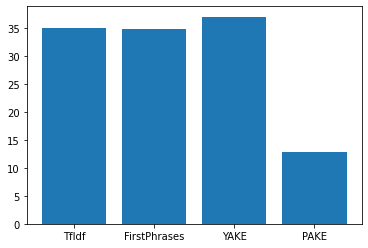

F@5


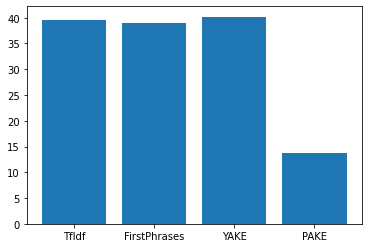

F@10


In [9]:
import matplotlib.pyplot as plt
import numpy as np
model_name = np.array([]) 
f_5 = np.array([]) 
f_10 = np.array([])
# loop through the models
for model in outputs:
    
    f_scores = []
    # compute the P, R, F scores for the model
    for cutoff in [5, 10]:
        scores = []
        for i, output in enumerate(outputs[model]):
            scores.append(evaluate(output, references[i], cutoff))

        # compute the average scores
        P, R, F = np.mean(scores, axis=0)
        f_scores.append(F)
        
    model_name = np.append(model_name, model) 
    f_5 = np.append(f_5, f_scores[0]*100) 
    f_10 = np.append(f_10, f_scores[1]*100) 

plt.bar(model_name, f_5)
plt.show()
print("F@5")
plt.bar(model_name, f_10)
plt.show()
print("F@10")